In [1]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from torch.distributions import Normal
import random
import time
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#####################  hyper parameters  ####################

MAX_EPISODES = 6001              
MAX_EP_STEPS = 60               

RENDER = False

LOAD_MEM = False
LOAD_MODEL = False
LOAD_FOLDER_NAME = '2450epi'

LOAD_PRETRAIN = False

CHECK_POINT_EPI = 50


ENV_NAME = 'OpenCabinetDrawer-v0'       
SEED = 123                      

var = 5
var_low_bound = 0.05



In [2]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,hidden_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.hidden_dim = hidden_dim
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                      # learning rate for actor
        self.lr_c = 0.001                                                                       # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        self.Success_record = np.zeros(MAX_EPISODES)
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound,hidden_size):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                
                self.linear1 = nn.Linear(s_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear4 = nn.Linear(hidden_size, a_dim)
                
                
                self.linear4.weight.data.uniform_(-0.03, 0.03)
                self.linear4.bias.data.uniform_(-0.03, 0.03)
#                 self.fc1 = nn.Linear(s_dim,256)
#                 self.fc1.weight.data.normal_(0,0.1)          # initialization
                
#                 self.fc2 = nn.Linear(256,512)
#                 self.fc2.weight.data.normal_(0,0.1)
#                                
#                 self.fc3 = nn.Linear(512,256)
#                 self.fc3.weight.data.normal_(0,0.1)
                
#                 self.out = nn.Linear(256,a_dim)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))
                x = F.tanh(self.linear4(x))
                
#                 x = self.fc1(x)
#                 x = F.relu(x)
#                  
#                 x = self.fc2(x)
#                 x = F.relu(x)
                
#                 x = self.fc3(x)
#                 x = F.relu(x)
                
#                 x = self.out(x)
#                 x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim,hidden_size):
                super(CNet,self).__init__()
                
                self.linear1 = nn.Linear(s_dim + a_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
#                 self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, 1)
                

                self.linear3.weight.data.uniform_(-0.03,0.03)
                self.linear3.bias.data.uniform_(-0.03,0.03)

#                 self.fcs1 = nn.Linear(s_dim,256)
#                 self.fcs1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs2 = nn.Linear(256,512)
#                 self.fcs2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs3 = nn.Linear(512,256)
#                 self.fcs3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01) 
                
#                 self.fca1 = nn.Linear(a_dim,256)
#                 self.fca1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fca2 = nn.Linear(256,512)
#                 self.fca2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)              
                
#                 self.fca3 = nn.Linear(512,256)
#                 self.fca3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.out = nn.Linear(256,1)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
        
                x = torch.cat([s, a], 1)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
#                 x = F.relu(self.linear3(x))
                x = self.linear3(x)

#                 x = self.fcs1(s)                              # 输入状态
#                 x = F.relu(x)
                
#                 x = self.fcs2(x)
#                 x = F.relu(x)
                
#                 x = self.fcs3(x)
#                 x = F.relu(x) 
                
#                 y = self.fca1(a)                              # 输入动作
#                 y = F.relu(y)
                
#                 y = self.fca2(y)                              
#                 y = F.relu(y)
                
#                 y = self.fca3(y)                              
#                 y = F.relu(y)
                
#                 net = F.relu(x+y)
#                 actions_value = self.out(net)                # 给出V(s,a)
                return x

        self.Actor_eval = ANet(s_dim, a_dim, a_bound, hidden_dim)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound, hidden_dim)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim,hidden_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim,hidden_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)

        return self.Actor_eval(s)[0].detach()                

    def learn(self):
        #self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = lr_a)  # actor的优化器
        #self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = lr_c) # critic的优化器
        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  

        loss_a = -torch.mean(q)            
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      
        q_ = self.Critic_target(bs_,a_)  
        q_target = br + self.gamma * q_  

        q_v = self.Critic_eval(bs,ba)

        td_error = self.loss_td(q_target,q_v)

        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                              
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def Record_success(self,epi):
        self.Success_record[epi] = 1
        
    def save(self,folder_name):
    
        if os.path.exists('./DPG model/' + folder_name):
            os.remove('./DPG model/' + folder_name)
            
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Success_record.csv'
        xml_df = pd.DataFrame(self.Success_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
#         ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_eval.eval()
#         ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_target.eval() 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/fyf0702/miniconda3/envs/mani_skill/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 0  Reward: -162 Explore: 5.00
Episode: 1  Reward: -708 Explore: 5.00
Episode: 2  Reward: -609 Explore: 5.00
Episode: 3  Reward: -564 Explore: 5.00
Episode: 4  Reward: -408 Explore: 5.00
Episode: 5  Reward: -689 Explore: 5.00
Episode: 6  Reward: -250 Explore: 5.00
Episode: 7  Reward: -398 Explore: 5.00
Episode: 8  Reward: -563 Explore: 5.00
Episode: 9  Reward: -915 Explore: 5.00
Episode: 10  Reward: -254 Explore: 5.00
Episode: 11  Reward: -319 Explore: 5.00
Episode: 12  Reward: -419 Explore: 5.00
Episode: 13  Reward: -545 Explore: 5.00
Episode: 14  Reward: -705 Explore: 5.00
Episode: 15  Reward: -713 Explore: 5.00
Episode: 16  Reward: -727 Explore: 5.00
Episode: 17  Reward: -357 Explore: 5.00
Episode: 18  Reward: -260 Explore: 5.00
Episode: 19  Reward: -389 Explore: 5.00
Episode: 20  Reward: -196 Explore: 5.00
Episode: 21  Reward: -572 Explore: 5.00
Episode: 22  Reward: -385 Explore: 5.00
Episode: 23  Reward: -442 Explore: 5.00
Episode: 24  Reward: -345 Explore: 5.00
Episode: 2

Episode: 203  Reward: -570 Explore: 1.63
Episode: 204  Reward: -161 Explore: 1.58
Episode: 205  Reward: -294 Explore: 1.54
Episode: 206  Reward: -229 Explore: 1.49
Episode: 207  Reward: -127 Explore: 1.45
Episode: 208  Reward: -165 Explore: 1.40
Episode: 209  Reward: -223 Explore: 1.36
Episode: 210  Reward: -194 Explore: 1.32
Episode: 211  Reward: -96 Explore: 1.28
Episode: 212  Reward: -186 Explore: 1.24
Episode: 213  Reward: -75 Explore: 1.21
Episode: 214  Reward: -137 Explore: 1.17
Episode: 215  Reward: -93 Explore: 1.14
Episode: 216  Reward: -276 Explore: 1.10
Episode: 217  Reward: -46 Explore: 1.07
Episode: 218  Reward: -97 Explore: 1.04
Episode: 219  Reward: 14 Explore: 1.01
Episode: 220  Reward: 1 Explore: 0.98
Episode: 221  Reward: 4 Explore: 0.95
Episode: 222  Reward: -232 Explore: 0.92
Episode: 223  Reward: -130 Explore: 0.89
Episode: 224  Reward: -11 Explore: 0.87
Episode: 225  Reward: 0 Explore: 0.84
Episode: 226  Reward: -84 Explore: 0.82
Episode: 227  Reward: 29 Explore: 

Episode: 410  Reward: -41 Explore: 0.05
Episode: 411  Reward: -73 Explore: 0.05
Episode: 412  Reward: 23 Explore: 0.05
Episode: 413  Reward: -66 Explore: 0.05
Episode: 414  Reward: 216 Explore: 0.05
Episode: 415  Reward: 51 Explore: 0.05
Episode: 416  Reward: 31 Explore: 0.05
Episode: 417  Reward: -41 Explore: 0.05
Episode: 418  Reward: -41 Explore: 0.05
Episode: 419  Reward: -6 Explore: 0.05
Episode: 420  Reward: 60 Explore: 0.05
Episode: 421  Reward: 69 Explore: 0.05
Episode: 422  Reward: -33 Explore: 0.05
Episode: 423  Reward: -40 Explore: 0.05
Episode: 424  Reward: -15 Explore: 0.05
Episode: 425  Reward: 113 Explore: 0.05
Episode: 426  Reward: 79 Explore: 0.05
Episode: 427  Reward: -41 Explore: 0.05
Episode: 428  Reward: 28 Explore: 0.05
Episode: 429  Reward: -143 Explore: 0.05
Episode: 430  Reward: -44 Explore: 0.05
Episode: 431  Reward: -10 Explore: 0.05
Episode: 432  Reward: 39 Explore: 0.05
Episode: 433  Reward: -5 Explore: 0.05
Episode: 434  Reward: 0 Explore: 0.05
Episode: 43

Episode: 615  Reward: -89 Explore: 0.05
Episode: 616  Reward: -96 Explore: 0.05
Episode: 617  Reward: 29 Explore: 0.05
Episode: 618  Reward: -156 Explore: 0.05
Episode: 619  Reward: 117 Explore: 0.05
Episode: 620  Reward: -91 Explore: 0.05
Episode: 621  Reward: -112 Explore: 0.05
Episode: 622  Reward: 102 Explore: 0.05
Episode: 623  Reward: -107 Explore: 0.05
Episode: 624  Reward: 52 Explore: 0.05
Episode: 625  Reward: -92 Explore: 0.05
Episode: 626  Reward: -125 Explore: 0.05
Episode: 627  Reward: -9 Explore: 0.05
Episode: 628  Reward: 45 Explore: 0.05
Episode: 629  Reward: -117 Explore: 0.05
Episode: 630  Reward: -128 Explore: 0.05
Episode: 631  Reward: -85 Explore: 0.05
Episode: 632  Reward: -149 Explore: 0.05
Episode: 633  Reward: -74 Explore: 0.05
Episode: 634  Reward: -105 Explore: 0.05
Episode: 635  Reward: -154 Explore: 0.05
Episode: 636  Reward: -32 Explore: 0.05
Episode: 637  Reward: -152 Explore: 0.05
Episode: 638  Reward: 20 Explore: 0.05
Episode: 639  Reward: -118 Explore:

SUCCESS
Episode: 821  Reward: 773 Explore: 0.05
Episode: 822  Reward: 96 Explore: 0.05
Episode: 823  Reward: 42 Explore: 0.05
Episode: 824  Reward: -252 Explore: 0.05
Episode: 825  Reward: -215 Explore: 0.05
Episode: 826  Reward: -94 Explore: 0.05
Episode: 827  Reward: -27 Explore: 0.05
Episode: 828  Reward: 50 Explore: 0.05
Episode: 829  Reward: 1 Explore: 0.05
Episode: 830  Reward: -1 Explore: 0.05
Episode: 831  Reward: 29 Explore: 0.05
Episode: 832  Reward: 27 Explore: 0.05
Episode: 833  Reward: 13 Explore: 0.05
Episode: 834  Reward: 48 Explore: 0.05
Episode: 835  Reward: -4 Explore: 0.05
Episode: 836  Reward: 668 Explore: 0.05
Episode: 837  Reward: 80 Explore: 0.05
Episode: 838  Reward: -58 Explore: 0.05
Episode: 839  Reward: -221 Explore: 0.05
Episode: 840  Reward: -110 Explore: 0.05
Episode: 841  Reward: -62 Explore: 0.05
Episode: 842  Reward: -3 Explore: 0.05
Episode: 843  Reward: 45 Explore: 0.05
Episode: 844  Reward: -17 Explore: 0.05
Episode: 845  Reward: 70 Explore: 0.05
Epi

Episode: 1028  Reward: 38 Explore: 0.05
Episode: 1029  Reward: -31 Explore: 0.05
Episode: 1030  Reward: 113 Explore: 0.05
Episode: 1031  Reward: 99 Explore: 0.05
Episode: 1032  Reward: 45 Explore: 0.05
Episode: 1033  Reward: 105 Explore: 0.05
Episode: 1034  Reward: -97 Explore: 0.05
SUCCESS
Episode: 1035  Reward: 863 Explore: 0.05
Episode: 1036  Reward: 108 Explore: 0.05
Episode: 1037  Reward: -12 Explore: 0.05
Episode: 1038  Reward: 55 Explore: 0.05
Episode: 1039  Reward: 18 Explore: 0.05
Episode: 1040  Reward: 191 Explore: 0.05
SUCCESS
Episode: 1041  Reward: 667 Explore: 0.05
Episode: 1042  Reward: 44 Explore: 0.05
Episode: 1043  Reward: 15 Explore: 0.05
Episode: 1044  Reward: 78 Explore: 0.05
SUCCESS
Episode: 1045  Reward: 563 Explore: 0.05
Episode: 1046  Reward: 123 Explore: 0.05
SUCCESS
Episode: 1047  Reward: 874 Explore: 0.05
Episode: 1048  Reward: -50 Explore: 0.05
Episode: 1049  Reward: 80 Explore: 0.05
Episode: 1050  Reward: -55 Explore: 0.05


/tmp/ipykernel_1490155/1934568889.py:234: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10), dpi=70)


Episode: 1051  Reward: 47 Explore: 0.05
Episode: 1052  Reward: 39 Explore: 0.05
Episode: 1053  Reward: 42 Explore: 0.05
Episode: 1054  Reward: -188 Explore: 0.05
Episode: 1055  Reward: -12 Explore: 0.05
Episode: 1056  Reward: -36 Explore: 0.05
Episode: 1057  Reward: -177 Explore: 0.05
Episode: 1058  Reward: 34 Explore: 0.05
Episode: 1059  Reward: -154 Explore: 0.05
Episode: 1060  Reward: -110 Explore: 0.05
SUCCESS
Episode: 1061  Reward: 691 Explore: 0.05
Episode: 1062  Reward: -97 Explore: 0.05
Episode: 1063  Reward: -268 Explore: 0.05
Episode: 1064  Reward: -22 Explore: 0.05
Episode: 1065  Reward: 24 Explore: 0.05
Episode: 1066  Reward: -74 Explore: 0.05
Episode: 1067  Reward: 295 Explore: 0.05
Episode: 1068  Reward: -14 Explore: 0.05
Episode: 1069  Reward: 188 Explore: 0.05
Episode: 1070  Reward: -44 Explore: 0.05
Episode: 1071  Reward: -124 Explore: 0.05
Episode: 1072  Reward: 4 Explore: 0.05
Episode: 1073  Reward: 12 Explore: 0.05
Episode: 1074  Reward: -128 Explore: 0.05
Episode: 

Episode: 1252  Reward: -111 Explore: 0.05
Episode: 1253  Reward: -12 Explore: 0.05
Episode: 1254  Reward: -58 Explore: 0.05
Episode: 1255  Reward: -72 Explore: 0.05
Episode: 1256  Reward: -144 Explore: 0.05
Episode: 1257  Reward: -38 Explore: 0.05
Episode: 1258  Reward: -170 Explore: 0.05
Episode: 1259  Reward: -39 Explore: 0.05
Episode: 1260  Reward: -62 Explore: 0.05
Episode: 1261  Reward: -172 Explore: 0.05
Episode: 1262  Reward: -76 Explore: 0.05
Episode: 1263  Reward: -77 Explore: 0.05
Episode: 1264  Reward: 10 Explore: 0.05
Episode: 1265  Reward: 84 Explore: 0.05
Episode: 1266  Reward: -157 Explore: 0.05
Episode: 1267  Reward: 44 Explore: 0.05
Episode: 1268  Reward: -100 Explore: 0.05
Episode: 1269  Reward: 68 Explore: 0.05
Episode: 1270  Reward: 19 Explore: 0.05
Episode: 1271  Reward: 43 Explore: 0.05
Episode: 1272  Reward: 29 Explore: 0.05
Episode: 1273  Reward: -216 Explore: 0.05
Episode: 1274  Reward: -142 Explore: 0.05
Episode: 1275  Reward: 114 Explore: 0.05
Episode: 1276  

Episode: 1454  Reward: -8 Explore: 0.05
Episode: 1455  Reward: 5 Explore: 0.05
SUCCESS
Episode: 1456  Reward: 693 Explore: 0.05
Episode: 1457  Reward: 74 Explore: 0.05
Episode: 1458  Reward: 74 Explore: 0.05
Episode: 1459  Reward: 43 Explore: 0.05
Episode: 1460  Reward: 28 Explore: 0.05
Episode: 1461  Reward: 25 Explore: 0.05
Episode: 1462  Reward: 9 Explore: 0.05
Episode: 1463  Reward: -19 Explore: 0.05
Episode: 1464  Reward: 233 Explore: 0.05
Episode: 1465  Reward: 59 Explore: 0.05
Episode: 1466  Reward: 21 Explore: 0.05
SUCCESS
Episode: 1467  Reward: 566 Explore: 0.05
Episode: 1468  Reward: -11 Explore: 0.05
Episode: 1469  Reward: -5 Explore: 0.05
Episode: 1470  Reward: 73 Explore: 0.05
Episode: 1471  Reward: 64 Explore: 0.05
Episode: 1472  Reward: 28 Explore: 0.05
Episode: 1473  Reward: -118 Explore: 0.05
Episode: 1474  Reward: -6 Explore: 0.05
Episode: 1475  Reward: -46 Explore: 0.05
Episode: 1476  Reward: -40 Explore: 0.05
Episode: 1477  Reward: -85 Explore: 0.05
Episode: 1478  R

SUCCESS
Episode: 1654  Reward: 850 Explore: 0.05
Episode: 1655  Reward: 8 Explore: 0.05
Episode: 1656  Reward: -138 Explore: 0.05
SUCCESS
Episode: 1657  Reward: 636 Explore: 0.05
Episode: 1658  Reward: 3 Explore: 0.05
Episode: 1659  Reward: -1 Explore: 0.05
Episode: 1660  Reward: -61 Explore: 0.05
Episode: 1661  Reward: 11 Explore: 0.05
Episode: 1662  Reward: -16 Explore: 0.05
Episode: 1663  Reward: -118 Explore: 0.05
Episode: 1664  Reward: -98 Explore: 0.05
Episode: 1665  Reward: -20 Explore: 0.05
Episode: 1666  Reward: -158 Explore: 0.05
Episode: 1667  Reward: -40 Explore: 0.05
Episode: 1668  Reward: -123 Explore: 0.05
Episode: 1669  Reward: 24 Explore: 0.05
Episode: 1670  Reward: -35 Explore: 0.05
Episode: 1671  Reward: -27 Explore: 0.05
Episode: 1672  Reward: 156 Explore: 0.05
Episode: 1673  Reward: -118 Explore: 0.05
SUCCESS
Episode: 1674  Reward: 691 Explore: 0.05
SUCCESS
Episode: 1675  Reward: 662 Explore: 0.05
Episode: 1676  Reward: -121 Explore: 0.05
Episode: 1677  Reward: -18

Episode: 1852  Reward: -26 Explore: 0.05
Episode: 1853  Reward: -12 Explore: 0.05
Episode: 1854  Reward: 0 Explore: 0.05
SUCCESS
Episode: 1855  Reward: 772 Explore: 0.05
Episode: 1856  Reward: 25 Explore: 0.05
SUCCESS
Episode: 1857  Reward: 770 Explore: 0.05
Episode: 1858  Reward: -31 Explore: 0.05
Episode: 1859  Reward: -78 Explore: 0.05
Episode: 1860  Reward: 16 Explore: 0.05
Episode: 1861  Reward: -39 Explore: 0.05
Episode: 1862  Reward: -66 Explore: 0.05
Episode: 1863  Reward: -55 Explore: 0.05
Episode: 1864  Reward: -62 Explore: 0.05
Episode: 1865  Reward: -79 Explore: 0.05
Episode: 1866  Reward: -57 Explore: 0.05
Episode: 1867  Reward: 2 Explore: 0.05
Episode: 1868  Reward: -35 Explore: 0.05
Episode: 1869  Reward: -51 Explore: 0.05
Episode: 1870  Reward: -82 Explore: 0.05
SUCCESS
Episode: 1871  Reward: 602 Explore: 0.05
Episode: 1872  Reward: -116 Explore: 0.05
Episode: 1873  Reward: -48 Explore: 0.05
Episode: 1874  Reward: -3 Explore: 0.05
Episode: 1875  Reward: -16 Explore: 0.0

Episode: 2052  Reward: -114 Explore: 0.05
Episode: 2053  Reward: -94 Explore: 0.05
Episode: 2054  Reward: -139 Explore: 0.05
Episode: 2055  Reward: -152 Explore: 0.05
Episode: 2056  Reward: -22 Explore: 0.05
Episode: 2057  Reward: -191 Explore: 0.05
Episode: 2058  Reward: -36 Explore: 0.05
Episode: 2059  Reward: -55 Explore: 0.05
Episode: 2060  Reward: -121 Explore: 0.05
Episode: 2061  Reward: -20 Explore: 0.05
Episode: 2062  Reward: -72 Explore: 0.05
Episode: 2063  Reward: -28 Explore: 0.05
Episode: 2064  Reward: 43 Explore: 0.05
Episode: 2065  Reward: -67 Explore: 0.05
Episode: 2066  Reward: -2 Explore: 0.05
Episode: 2067  Reward: -167 Explore: 0.05
Episode: 2068  Reward: 72 Explore: 0.05
Episode: 2069  Reward: -39 Explore: 0.05
Episode: 2070  Reward: 36 Explore: 0.05
Episode: 2071  Reward: -167 Explore: 0.05
Episode: 2072  Reward: 14 Explore: 0.05
Episode: 2073  Reward: 267 Explore: 0.05
Episode: 2074  Reward: -11 Explore: 0.05
Episode: 2075  Reward: -5 Explore: 0.05
Episode: 2076  

Episode: 2252  Reward: -43 Explore: 0.05
Episode: 2253  Reward: -30 Explore: 0.05
Episode: 2254  Reward: 4 Explore: 0.05
Episode: 2255  Reward: -13 Explore: 0.05
Episode: 2256  Reward: -57 Explore: 0.05
Episode: 2257  Reward: 9 Explore: 0.05
Episode: 2258  Reward: 36 Explore: 0.05
Episode: 2259  Reward: 253 Explore: 0.05
Episode: 2260  Reward: 160 Explore: 0.05
Episode: 2261  Reward: 55 Explore: 0.05
Episode: 2262  Reward: 0 Explore: 0.05
Episode: 2263  Reward: 10 Explore: 0.05
Episode: 2264  Reward: -1 Explore: 0.05
Episode: 2265  Reward: 7 Explore: 0.05
Episode: 2266  Reward: 152 Explore: 0.05
Episode: 2267  Reward: 12 Explore: 0.05
SUCCESS
Episode: 2268  Reward: 790 Explore: 0.05
Episode: 2269  Reward: 292 Explore: 0.05
Episode: 2270  Reward: 34 Explore: 0.05
Episode: 2271  Reward: 82 Explore: 0.05
Episode: 2272  Reward: -11 Explore: 0.05
SUCCESS
Episode: 2273  Reward: 844 Explore: 0.05
Episode: 2274  Reward: -12 Explore: 0.05
Episode: 2275  Reward: 50 Explore: 0.05
Episode: 2276  R

Episode: 2453  Reward: 31 Explore: 0.05
Episode: 2454  Reward: 0 Explore: 0.05
Episode: 2455  Reward: -148 Explore: 0.05
Episode: 2456  Reward: 73 Explore: 0.05
Episode: 2457  Reward: -46 Explore: 0.05
Episode: 2458  Reward: 8 Explore: 0.05
Episode: 2459  Reward: 1 Explore: 0.05
Episode: 2460  Reward: 74 Explore: 0.05
Episode: 2461  Reward: -46 Explore: 0.05
Episode: 2462  Reward: 15 Explore: 0.05
Episode: 2463  Reward: 32 Explore: 0.05
Episode: 2464  Reward: -48 Explore: 0.05
Episode: 2465  Reward: -33 Explore: 0.05
Episode: 2466  Reward: -9 Explore: 0.05
Episode: 2467  Reward: 92 Explore: 0.05
Episode: 2468  Reward: -46 Explore: 0.05
Episode: 2469  Reward: -122 Explore: 0.05
Episode: 2470  Reward: -143 Explore: 0.05
Episode: 2471  Reward: -124 Explore: 0.05
Episode: 2472  Reward: -96 Explore: 0.05
Episode: 2473  Reward: 34 Explore: 0.05
Episode: 2474  Reward: -97 Explore: 0.05
Episode: 2475  Reward: -98 Explore: 0.05
Episode: 2476  Reward: -30 Explore: 0.05
Episode: 2477  Reward: -7 

Episode: 2651  Reward: -159 Explore: 0.05
Episode: 2652  Reward: -139 Explore: 0.05
Episode: 2653  Reward: -209 Explore: 0.05
Episode: 2654  Reward: -197 Explore: 0.05
Episode: 2655  Reward: -92 Explore: 0.05
Episode: 2656  Reward: -213 Explore: 0.05
Episode: 2657  Reward: -37 Explore: 0.05
Episode: 2658  Reward: 11 Explore: 0.05
Episode: 2659  Reward: -182 Explore: 0.05
Episode: 2660  Reward: -264 Explore: 0.05
Episode: 2661  Reward: -162 Explore: 0.05
Episode: 2662  Reward: -66 Explore: 0.05
Episode: 2663  Reward: -211 Explore: 0.05
Episode: 2664  Reward: -259 Explore: 0.05
Episode: 2665  Reward: -196 Explore: 0.05
Episode: 2666  Reward: -103 Explore: 0.05
Episode: 2667  Reward: -85 Explore: 0.05
Episode: 2668  Reward: -68 Explore: 0.05
Episode: 2669  Reward: -370 Explore: 0.05
Episode: 2670  Reward: -19 Explore: 0.05
Episode: 2671  Reward: -37 Explore: 0.05
Episode: 2672  Reward: -71 Explore: 0.05
Episode: 2673  Reward: -20 Explore: 0.05
Episode: 2674  Reward: -52 Explore: 0.05
Epis

Episode: 2848  Reward: -164 Explore: 0.05
Episode: 2849  Reward: -94 Explore: 0.05
Episode: 2850  Reward: -78 Explore: 0.05
Episode: 2851  Reward: -61 Explore: 0.05
Episode: 2852  Reward: -51 Explore: 0.05
Episode: 2853  Reward: -4 Explore: 0.05
Episode: 2854  Reward: -66 Explore: 0.05
Episode: 2855  Reward: -40 Explore: 0.05
Episode: 2856  Reward: -140 Explore: 0.05
Episode: 2857  Reward: -106 Explore: 0.05
Episode: 2858  Reward: -124 Explore: 0.05
Episode: 2859  Reward: -158 Explore: 0.05
Episode: 2860  Reward: -115 Explore: 0.05
Episode: 2861  Reward: -246 Explore: 0.05
Episode: 2862  Reward: -281 Explore: 0.05
Episode: 2863  Reward: -143 Explore: 0.05
Episode: 2864  Reward: -28 Explore: 0.05
Episode: 2865  Reward: -150 Explore: 0.05
Episode: 2866  Reward: -128 Explore: 0.05
Episode: 2867  Reward: -30 Explore: 0.05
Episode: 2868  Reward: -124 Explore: 0.05
SUCCESS
Episode: 2869  Reward: 837 Explore: 0.05
Episode: 2870  Reward: -62 Explore: 0.05
Episode: 2871  Reward: -247 Explore: 0

Episode: 3047  Reward: -88 Explore: 0.05
Episode: 3048  Reward: -113 Explore: 0.05
Episode: 3049  Reward: -2 Explore: 0.05
Episode: 3050  Reward: -70 Explore: 0.05
Episode: 3051  Reward: -22 Explore: 0.05
Episode: 3052  Reward: -34 Explore: 0.05
Episode: 3053  Reward: -3 Explore: 0.05
Episode: 3054  Reward: -49 Explore: 0.05
Episode: 3055  Reward: -12 Explore: 0.05
Episode: 3056  Reward: 2 Explore: 0.05
Episode: 3057  Reward: -59 Explore: 0.05
Episode: 3058  Reward: -17 Explore: 0.05
Episode: 3059  Reward: -31 Explore: 0.05
Episode: 3060  Reward: 4 Explore: 0.05
Episode: 3061  Reward: 27 Explore: 0.05
Episode: 3062  Reward: -28 Explore: 0.05
Episode: 3063  Reward: -21 Explore: 0.05
Episode: 3064  Reward: 40 Explore: 0.05
Episode: 3065  Reward: -19 Explore: 0.05
Episode: 3066  Reward: 12 Explore: 0.05
Episode: 3067  Reward: 45 Explore: 0.05
Episode: 3068  Reward: -13 Explore: 0.05
Episode: 3069  Reward: 40 Explore: 0.05
Episode: 3070  Reward: -13 Explore: 0.05
Episode: 3071  Reward: 561

Episode: 3248  Reward: 132 Explore: 0.05
Episode: 3249  Reward: -11 Explore: 0.05
Episode: 3250  Reward: -38 Explore: 0.05
Episode: 3251  Reward: -27 Explore: 0.05
SUCCESS
Episode: 3252  Reward: 832 Explore: 0.05
Episode: 3253  Reward: -4 Explore: 0.05
Episode: 3254  Reward: 87 Explore: 0.05
Episode: 3255  Reward: -53 Explore: 0.05
Episode: 3256  Reward: 58 Explore: 0.05
SUCCESS
Episode: 3257  Reward: 812 Explore: 0.05
Episode: 3258  Reward: 16 Explore: 0.05
Episode: 3259  Reward: -44 Explore: 0.05
Episode: 3260  Reward: -11 Explore: 0.05
Episode: 3261  Reward: 48 Explore: 0.05
Episode: 3262  Reward: 258 Explore: 0.05
Episode: 3263  Reward: 8 Explore: 0.05
Episode: 3264  Reward: 0 Explore: 0.05
Episode: 3265  Reward: 21 Explore: 0.05
Episode: 3266  Reward: 80 Explore: 0.05
Episode: 3267  Reward: -16 Explore: 0.05
Episode: 3268  Reward: -75 Explore: 0.05
Episode: 3269  Reward: 38 Explore: 0.05
Episode: 3270  Reward: 12 Explore: 0.05
SUCCESS
Episode: 3271  Reward: 895 Explore: 0.05
Episo

Episode: 3444  Reward: -43 Explore: 0.05
Episode: 3445  Reward: -70 Explore: 0.05
Episode: 3446  Reward: -66 Explore: 0.05
Episode: 3447  Reward: -112 Explore: 0.05
SUCCESS
Episode: 3448  Reward: 812 Explore: 0.05
Episode: 3449  Reward: -93 Explore: 0.05
Episode: 3450  Reward: -60 Explore: 0.05
Episode: 3451  Reward: 562 Explore: 0.05
Episode: 3452  Reward: -78 Explore: 0.05
Episode: 3453  Reward: -109 Explore: 0.05
Episode: 3454  Reward: -111 Explore: 0.05
Episode: 3455  Reward: -88 Explore: 0.05
Episode: 3456  Reward: -84 Explore: 0.05
Episode: 3457  Reward: -96 Explore: 0.05
Episode: 3458  Reward: -110 Explore: 0.05
Episode: 3459  Reward: -69 Explore: 0.05
SUCCESS
Episode: 3460  Reward: 913 Explore: 0.05
Episode: 3461  Reward: -119 Explore: 0.05
Episode: 3462  Reward: -37 Explore: 0.05
Episode: 3463  Reward: -71 Explore: 0.05
Episode: 3464  Reward: 467 Explore: 0.05
Episode: 3465  Reward: -107 Explore: 0.05
Episode: 3466  Reward: -87 Explore: 0.05
SUCCESS
Episode: 3467  Reward: 1095

Episode: 3640  Reward: 284 Explore: 0.05
SUCCESS
Episode: 3641  Reward: 1003 Explore: 0.05
Episode: 3642  Reward: -50 Explore: 0.05
Episode: 3643  Reward: 18 Explore: 0.05
Episode: 3644  Reward: -132 Explore: 0.05
Episode: 3645  Reward: -192 Explore: 0.05
Episode: 3646  Reward: -32 Explore: 0.05
Episode: 3647  Reward: 3 Explore: 0.05
Episode: 3648  Reward: -58 Explore: 0.05
Episode: 3649  Reward: -22 Explore: 0.05
Episode: 3650  Reward: -21 Explore: 0.05
Episode: 3651  Reward: 474 Explore: 0.05
Episode: 3652  Reward: -34 Explore: 0.05
Episode: 3653  Reward: 15 Explore: 0.05
Episode: 3654  Reward: 0 Explore: 0.05
Episode: 3655  Reward: -31 Explore: 0.05
Episode: 3656  Reward: 28 Explore: 0.05
Episode: 3657  Reward: -74 Explore: 0.05
Episode: 3658  Reward: 109 Explore: 0.05
Episode: 3659  Reward: 0 Explore: 0.05
Episode: 3660  Reward: 17 Explore: 0.05
Episode: 3661  Reward: -23 Explore: 0.05
Episode: 3662  Reward: -2 Explore: 0.05
Episode: 3663  Reward: -6 Explore: 0.05
Episode: 3664  Re

Episode: 3840  Reward: -187 Explore: 0.05
SUCCESS
Episode: 3841  Reward: 789 Explore: 0.05
Episode: 3842  Reward: 210 Explore: 0.05
Episode: 3843  Reward: -79 Explore: 0.05
Episode: 3844  Reward: 31 Explore: 0.05
Episode: 3845  Reward: 24 Explore: 0.05
Episode: 3846  Reward: 15 Explore: 0.05
Episode: 3847  Reward: -100 Explore: 0.05
Episode: 3848  Reward: -11 Explore: 0.05
SUCCESS
Episode: 3849  Reward: 677 Explore: 0.05
Episode: 3850  Reward: -60 Explore: 0.05
Episode: 3851  Reward: 583 Explore: 0.05
Episode: 3852  Reward: -6 Explore: 0.05
Episode: 3853  Reward: 69 Explore: 0.05
Episode: 3854  Reward: 337 Explore: 0.05
Episode: 3855  Reward: 62 Explore: 0.05
Episode: 3856  Reward: 28 Explore: 0.05
Episode: 3857  Reward: 513 Explore: 0.05
Episode: 3858  Reward: 325 Explore: 0.05
Episode: 3859  Reward: -67 Explore: 0.05
Episode: 3860  Reward: 36 Explore: 0.05
Episode: 3861  Reward: 11 Explore: 0.05
Episode: 3862  Reward: 392 Explore: 0.05
Episode: 3863  Reward: 527 Explore: 0.05
Episode

SUCCESS
Episode: 4036  Reward: 903 Explore: 0.05
SUCCESS
Episode: 4037  Reward: 892 Explore: 0.05
SUCCESS
Episode: 4038  Reward: 648 Explore: 0.05
SUCCESS
Episode: 4039  Reward: 1098 Explore: 0.05
Episode: 4040  Reward: 170 Explore: 0.05
Episode: 4041  Reward: -9 Explore: 0.05
Episode: 4042  Reward: 72 Explore: 0.05
Episode: 4043  Reward: 296 Explore: 0.05
Episode: 4044  Reward: -18 Explore: 0.05
Episode: 4045  Reward: -7 Explore: 0.05
Episode: 4046  Reward: -67 Explore: 0.05
Episode: 4047  Reward: -155 Explore: 0.05
Episode: 4048  Reward: 31 Explore: 0.05
Episode: 4049  Reward: 66 Explore: 0.05
Episode: 4050  Reward: -18 Explore: 0.05
Episode: 4051  Reward: 308 Explore: 0.05
SUCCESS
Episode: 4052  Reward: 764 Explore: 0.05
Episode: 4053  Reward: 317 Explore: 0.05
Episode: 4054  Reward: 441 Explore: 0.05
SUCCESS
Episode: 4055  Reward: 1051 Explore: 0.05
Episode: 4056  Reward: 389 Explore: 0.05
Episode: 4057  Reward: 344 Explore: 0.05
SUCCESS
Episode: 4058  Reward: 612 Explore: 0.05
SUC

Episode: 4227  Reward: -101 Explore: 0.05
Episode: 4228  Reward: 173 Explore: 0.05
SUCCESS
Episode: 4229  Reward: 637 Explore: 0.05
SUCCESS
Episode: 4230  Reward: 1212 Explore: 0.05
SUCCESS
Episode: 4231  Reward: 921 Explore: 0.05
SUCCESS
Episode: 4232  Reward: 697 Explore: 0.05
Episode: 4233  Reward: -106 Explore: 0.05
Episode: 4234  Reward: -186 Explore: 0.05
Episode: 4235  Reward: -126 Explore: 0.05
SUCCESS
Episode: 4236  Reward: 1067 Explore: 0.05
SUCCESS
Episode: 4237  Reward: 846 Explore: 0.05
Episode: 4238  Reward: -96 Explore: 0.05
SUCCESS
Episode: 4239  Reward: 973 Explore: 0.05
Episode: 4240  Reward: -60 Explore: 0.05
Episode: 4241  Reward: -159 Explore: 0.05
SUCCESS
Episode: 4242  Reward: 887 Explore: 0.05
SUCCESS
Episode: 4243  Reward: 725 Explore: 0.05
Episode: 4244  Reward: -3 Explore: 0.05
SUCCESS
Episode: 4245  Reward: 856 Explore: 0.05
SUCCESS
Episode: 4246  Reward: 712 Explore: 0.05
SUCCESS
Episode: 4247  Reward: 733 Explore: 0.05
Episode: 4248  Reward: 466 Explore: 0

Episode: 4410  Reward: -331 Explore: 0.05
SUCCESS
Episode: 4411  Reward: 902 Explore: 0.05
Episode: 4412  Reward: 6 Explore: 0.05
Episode: 4413  Reward: -270 Explore: 0.05
Episode: 4414  Reward: 575 Explore: 0.05
Episode: 4415  Reward: 680 Explore: 0.05
Episode: 4416  Reward: -161 Explore: 0.05
Episode: 4417  Reward: 651 Explore: 0.05
Episode: 4418  Reward: -59 Explore: 0.05
Episode: 4419  Reward: -222 Explore: 0.05
Episode: 4420  Reward: -211 Explore: 0.05
Episode: 4421  Reward: -284 Explore: 0.05
SUCCESS
Episode: 4422  Reward: 974 Explore: 0.05
SUCCESS
Episode: 4423  Reward: 763 Explore: 0.05
SUCCESS
Episode: 4424  Reward: 845 Explore: 0.05
SUCCESS
Episode: 4425  Reward: 821 Explore: 0.05
Episode: 4426  Reward: -68 Explore: 0.05
Episode: 4427  Reward: -145 Explore: 0.05
SUCCESS
Episode: 4428  Reward: 933 Explore: 0.05
Episode: 4429  Reward: -250 Explore: 0.05
SUCCESS
Episode: 4430  Reward: 928 Explore: 0.05
Episode: 4431  Reward: -431 Explore: 0.05
Episode: 4432  Reward: -187 Explore

Episode: 4597  Reward: -105 Explore: 0.05
Episode: 4598  Reward: -102 Explore: 0.05
Episode: 4599  Reward: -181 Explore: 0.05
Episode: 4600  Reward: 57 Explore: 0.05
SUCCESS
Episode: 4601  Reward: 924 Explore: 0.05
Episode: 4602  Reward: -25 Explore: 0.05
Episode: 4603  Reward: -110 Explore: 0.05
Episode: 4604  Reward: -95 Explore: 0.05
Episode: 4605  Reward: -218 Explore: 0.05
Episode: 4606  Reward: -206 Explore: 0.05
SUCCESS
Episode: 4607  Reward: 911 Explore: 0.05
SUCCESS
Episode: 4608  Reward: 647 Explore: 0.05
Episode: 4609  Reward: -119 Explore: 0.05
SUCCESS
Episode: 4610  Reward: 884 Explore: 0.05
Episode: 4611  Reward: -148 Explore: 0.05
SUCCESS
Episode: 4612  Reward: 831 Explore: 0.05
SUCCESS
Episode: 4613  Reward: 1370 Explore: 0.05
SUCCESS
Episode: 4614  Reward: 1057 Explore: 0.05
Episode: 4615  Reward: -106 Explore: 0.05
SUCCESS
Episode: 4616  Reward: 1038 Explore: 0.05
SUCCESS
Episode: 4617  Reward: 737 Explore: 0.05
Episode: 4618  Reward: -94 Explore: 0.05
SUCCESS
Episode

Episode: 4785  Reward: -144 Explore: 0.05
Episode: 4786  Reward: -158 Explore: 0.05
SUCCESS
Episode: 4787  Reward: 1182 Explore: 0.05
SUCCESS
Episode: 4788  Reward: 853 Explore: 0.05
Episode: 4789  Reward: 179 Explore: 0.05
SUCCESS
Episode: 4790  Reward: 769 Explore: 0.05
Episode: 4791  Reward: 4 Explore: 0.05
Episode: 4792  Reward: 10 Explore: 0.05
Episode: 4793  Reward: -65 Explore: 0.05
Episode: 4794  Reward: -83 Explore: 0.05
SUCCESS
Episode: 4795  Reward: 807 Explore: 0.05
Episode: 4796  Reward: -61 Explore: 0.05
Episode: 4797  Reward: -1 Explore: 0.05
SUCCESS
Episode: 4798  Reward: 897 Explore: 0.05
SUCCESS
Episode: 4799  Reward: 800 Explore: 0.05
Episode: 4800  Reward: -161 Explore: 0.05
Episode: 4801  Reward: -105 Explore: 0.05
Episode: 4802  Reward: -181 Explore: 0.05
Episode: 4803  Reward: -187 Explore: 0.05
SUCCESS
Episode: 4804  Reward: 732 Explore: 0.05
Episode: 4805  Reward: 36 Explore: 0.05
Episode: 4806  Reward: -184 Explore: 0.05
Episode: 4807  Reward: -111 Explore: 0.

SUCCESS
Episode: 4974  Reward: 885 Explore: 0.05
Episode: 4975  Reward: -149 Explore: 0.05
Episode: 4976  Reward: -7 Explore: 0.05
SUCCESS
Episode: 4977  Reward: 780 Explore: 0.05
Episode: 4978  Reward: -126 Explore: 0.05
SUCCESS
Episode: 4979  Reward: 543 Explore: 0.05
Episode: 4980  Reward: -16 Explore: 0.05
Episode: 4981  Reward: -36 Explore: 0.05
Episode: 4982  Reward: -50 Explore: 0.05
SUCCESS
Episode: 4983  Reward: 589 Explore: 0.05
Episode: 4984  Reward: -37 Explore: 0.05
Episode: 4985  Reward: -33 Explore: 0.05
Episode: 4986  Reward: 257 Explore: 0.05
Episode: 4987  Reward: -68 Explore: 0.05
SUCCESS
Episode: 4988  Reward: 849 Explore: 0.05
Episode: 4989  Reward: 3 Explore: 0.05
Episode: 4990  Reward: 26 Explore: 0.05
Episode: 4991  Reward: 22 Explore: 0.05
Episode: 4992  Reward: -152 Explore: 0.05
Episode: 4993  Reward: -81 Explore: 0.05
Episode: 4994  Reward: -145 Explore: 0.05
SUCCESS
Episode: 4995  Reward: 999 Explore: 0.05
SUCCESS
Episode: 4996  Reward: 711 Explore: 0.05
SU

Episode: 5161  Reward: 36 Explore: 0.05
Episode: 5162  Reward: -22 Explore: 0.05
Episode: 5163  Reward: -81 Explore: 0.05
Episode: 5164  Reward: -14 Explore: 0.05
Episode: 5165  Reward: 298 Explore: 0.05
SUCCESS
Episode: 5166  Reward: 631 Explore: 0.05
Episode: 5167  Reward: -50 Explore: 0.05
Episode: 5168  Reward: -72 Explore: 0.05
SUCCESS
Episode: 5169  Reward: 531 Explore: 0.05
Episode: 5170  Reward: 280 Explore: 0.05
Episode: 5171  Reward: -46 Explore: 0.05
Episode: 5172  Reward: -21 Explore: 0.05
Episode: 5173  Reward: -35 Explore: 0.05
Episode: 5174  Reward: -72 Explore: 0.05
SUCCESS
Episode: 5175  Reward: 844 Explore: 0.05
SUCCESS
Episode: 5176  Reward: 821 Explore: 0.05
SUCCESS
Episode: 5177  Reward: 936 Explore: 0.05
SUCCESS
Episode: 5178  Reward: 899 Explore: 0.05
Episode: 5179  Reward: -79 Explore: 0.05
SUCCESS
Episode: 5180  Reward: 1001 Explore: 0.05
SUCCESS
Episode: 5181  Reward: 1131 Explore: 0.05
Episode: 5182  Reward: 190 Explore: 0.05
SUCCESS
Episode: 5183  Reward: 76

SUCCESS
Episode: 5342  Reward: 870 Explore: 0.05
Episode: 5343  Reward: 3 Explore: 0.05
Episode: 5344  Reward: -65 Explore: 0.05
Episode: 5345  Reward: 306 Explore: 0.05
SUCCESS
Episode: 5346  Reward: 649 Explore: 0.05
SUCCESS
Episode: 5347  Reward: 806 Explore: 0.05
SUCCESS
Episode: 5348  Reward: 830 Explore: 0.05
SUCCESS
Episode: 5349  Reward: 915 Explore: 0.05
Episode: 5350  Reward: -19 Explore: 0.05
Episode: 5351  Reward: -148 Explore: 0.05
Episode: 5352  Reward: -59 Explore: 0.05
Episode: 5353  Reward: 404 Explore: 0.05
SUCCESS
Episode: 5354  Reward: 690 Explore: 0.05
Episode: 5355  Reward: -130 Explore: 0.05
Episode: 5356  Reward: 142 Explore: 0.05
Episode: 5357  Reward: 254 Explore: 0.05
Episode: 5358  Reward: -121 Explore: 0.05
Episode: 5359  Reward: -16 Explore: 0.05
SUCCESS
Episode: 5360  Reward: 863 Explore: 0.05
Episode: 5361  Reward: 241 Explore: 0.05
Episode: 5362  Reward: -142 Explore: 0.05
SUCCESS
Episode: 5363  Reward: 994 Explore: 0.05
Episode: 5364  Reward: -24 Explo

Episode: 5526  Reward: -78 Explore: 0.05
Episode: 5527  Reward: -51 Explore: 0.05
SUCCESS
Episode: 5528  Reward: 763 Explore: 0.05
Episode: 5529  Reward: -104 Explore: 0.05
SUCCESS
Episode: 5530  Reward: 701 Explore: 0.05
SUCCESS
Episode: 5531  Reward: 879 Explore: 0.05
SUCCESS
Episode: 5532  Reward: 773 Explore: 0.05
SUCCESS
Episode: 5533  Reward: 896 Explore: 0.05
Episode: 5534  Reward: 2 Explore: 0.05
Episode: 5535  Reward: 184 Explore: 0.05
Episode: 5536  Reward: -87 Explore: 0.05
SUCCESS
Episode: 5537  Reward: 794 Explore: 0.05
SUCCESS
Episode: 5538  Reward: 986 Explore: 0.05
Episode: 5539  Reward: -37 Explore: 0.05
Episode: 5540  Reward: -101 Explore: 0.05
Episode: 5541  Reward: -66 Explore: 0.05
Episode: 5542  Reward: 69 Explore: 0.05
SUCCESS
Episode: 5543  Reward: 995 Explore: 0.05
Episode: 5544  Reward: -96 Explore: 0.05
Episode: 5545  Reward: -85 Explore: 0.05
Episode: 5546  Reward: 60 Explore: 0.05
SUCCESS
Episode: 5547  Reward: 1087 Explore: 0.05
Episode: 5548  Reward: -89 

SUCCESS
Episode: 5716  Reward: 837 Explore: 0.05
SUCCESS
Episode: 5717  Reward: 688 Explore: 0.05
Episode: 5718  Reward: -104 Explore: 0.05
Episode: 5719  Reward: -33 Explore: 0.05
Episode: 5720  Reward: 3 Explore: 0.05
SUCCESS
Episode: 5721  Reward: 827 Explore: 0.05
Episode: 5722  Reward: -66 Explore: 0.05
Episode: 5723  Reward: 3 Explore: 0.05
Episode: 5724  Reward: -192 Explore: 0.05
Episode: 5725  Reward: 188 Explore: 0.05
SUCCESS
Episode: 5726  Reward: 841 Explore: 0.05
Episode: 5727  Reward: 246 Explore: 0.05
SUCCESS
Episode: 5728  Reward: 847 Explore: 0.05
SUCCESS
Episode: 5729  Reward: 911 Explore: 0.05
SUCCESS
Episode: 5730  Reward: 756 Explore: 0.05
SUCCESS
Episode: 5731  Reward: 1000 Explore: 0.05
Episode: 5732  Reward: -53 Explore: 0.05
Episode: 5733  Reward: 703 Explore: 0.05
Episode: 5734  Reward: -75 Explore: 0.05
SUCCESS
Episode: 5735  Reward: 993 Explore: 0.05
Episode: 5736  Reward: -109 Explore: 0.05
Episode: 5737  Reward: -92 Explore: 0.05
Episode: 5738  Reward: -96

Episode: 5906  Reward: 247 Explore: 0.05
Episode: 5907  Reward: -149 Explore: 0.05
Episode: 5908  Reward: 96 Explore: 0.05
Episode: 5909  Reward: -54 Explore: 0.05
Episode: 5910  Reward: 258 Explore: 0.05
Episode: 5911  Reward: -132 Explore: 0.05
Episode: 5912  Reward: 216 Explore: 0.05
Episode: 5913  Reward: 105 Explore: 0.05
Episode: 5914  Reward: -61 Explore: 0.05
Episode: 5915  Reward: 791 Explore: 0.05
Episode: 5916  Reward: 534 Explore: 0.05
Episode: 5917  Reward: -41 Explore: 0.05
SUCCESS
Episode: 5918  Reward: 688 Explore: 0.05
Episode: 5919  Reward: 1 Explore: 0.05
Episode: 5920  Reward: 19 Explore: 0.05
Episode: 5921  Reward: -61 Explore: 0.05
Episode: 5922  Reward: -94 Explore: 0.05
Episode: 5923  Reward: -45 Explore: 0.05
Episode: 5924  Reward: -17 Explore: 0.05
Episode: 5925  Reward: 57 Explore: 0.05
SUCCESS
Episode: 5926  Reward: 1015 Explore: 0.05
Episode: 5927  Reward: 267 Explore: 0.05
Episode: 5928  Reward: 8 Explore: 0.05
Episode: 5929  Reward: 295 Explore: 0.05
Epis

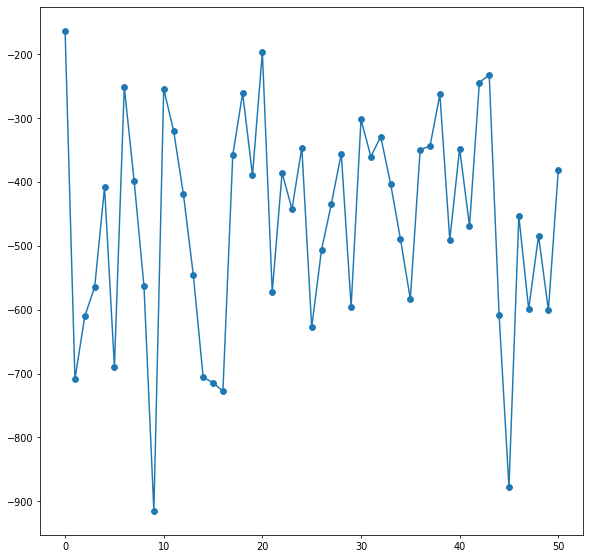

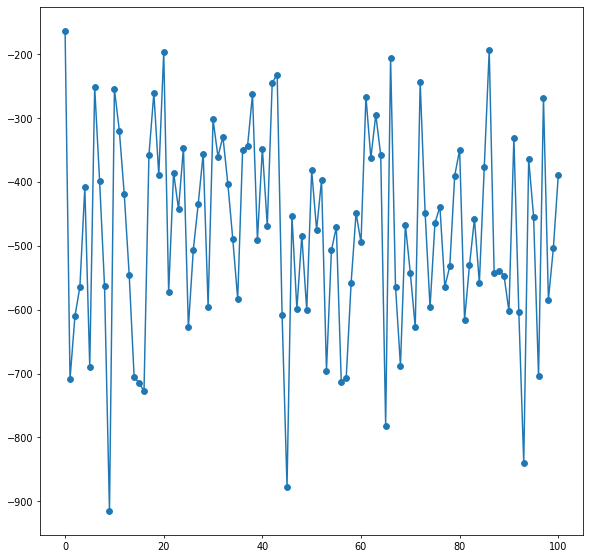

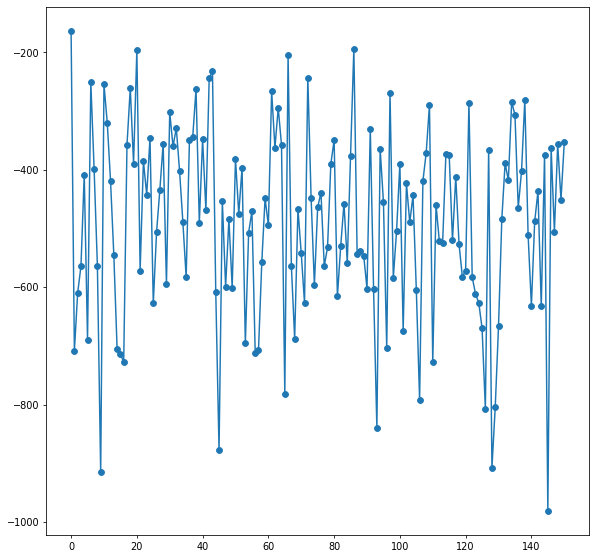

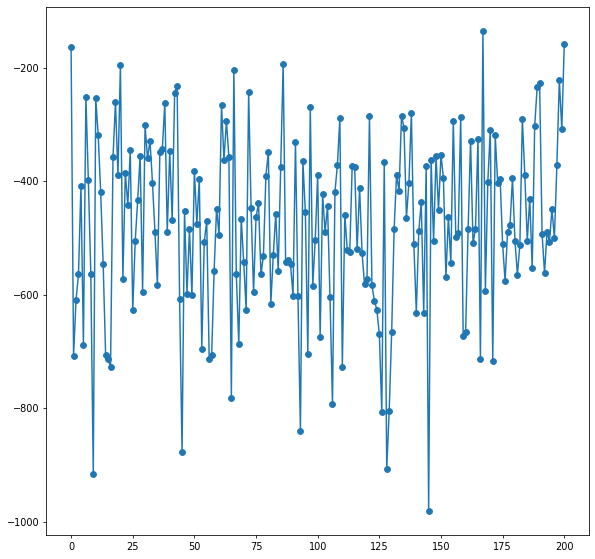

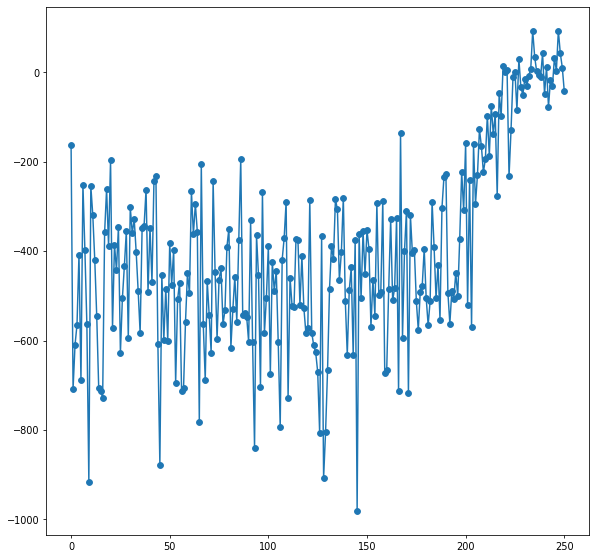

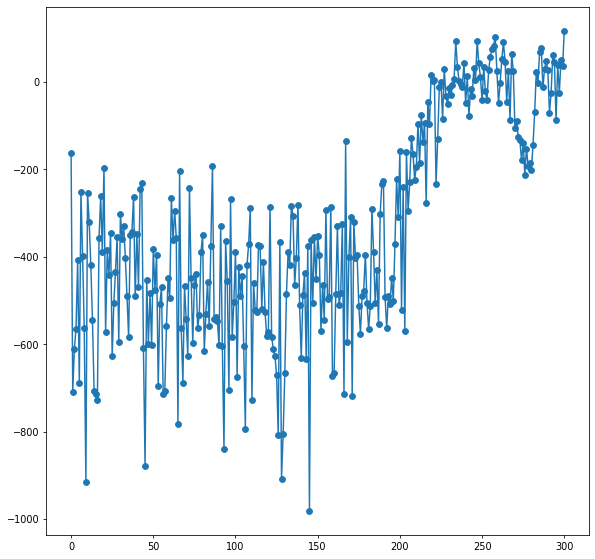

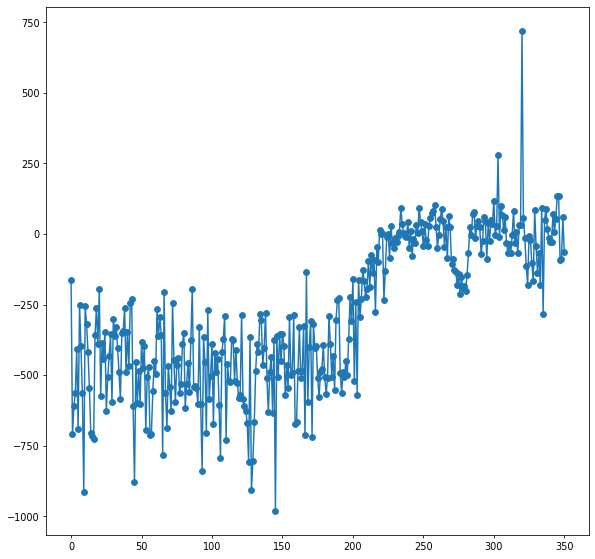

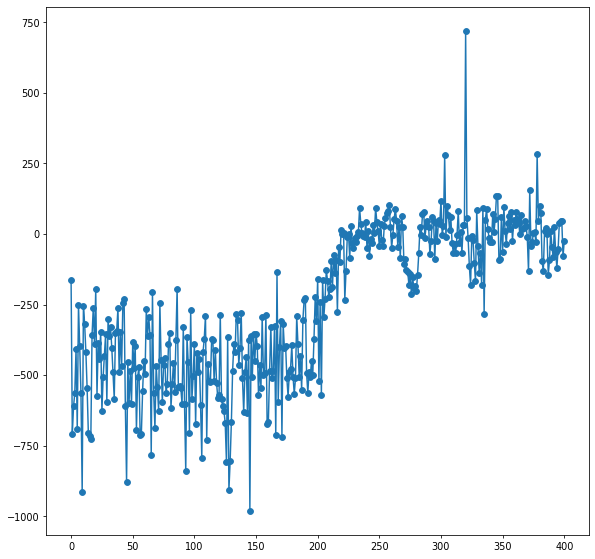

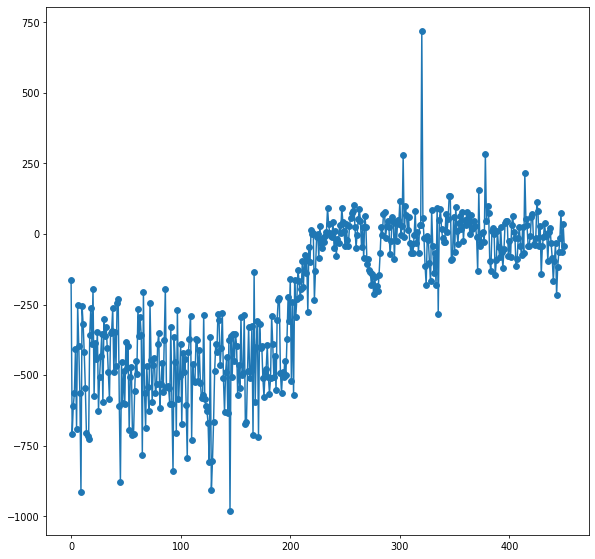

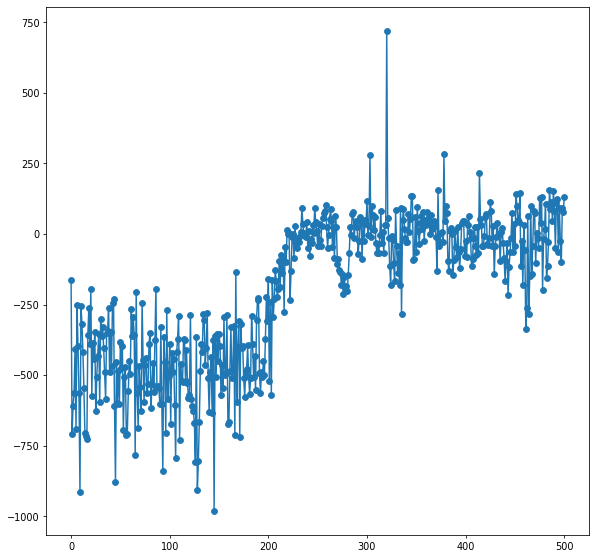

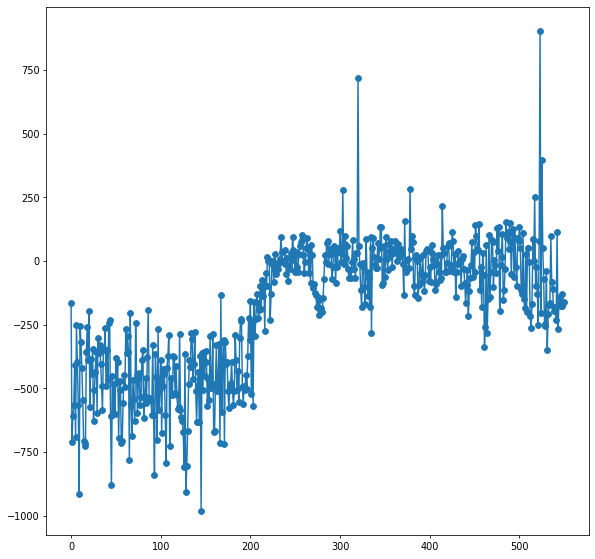

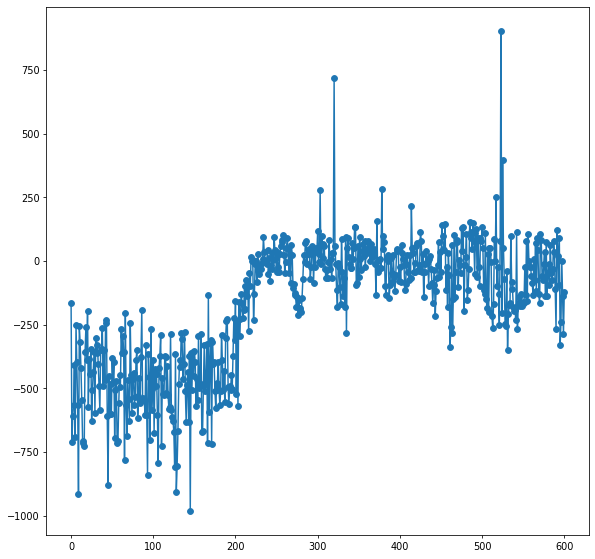

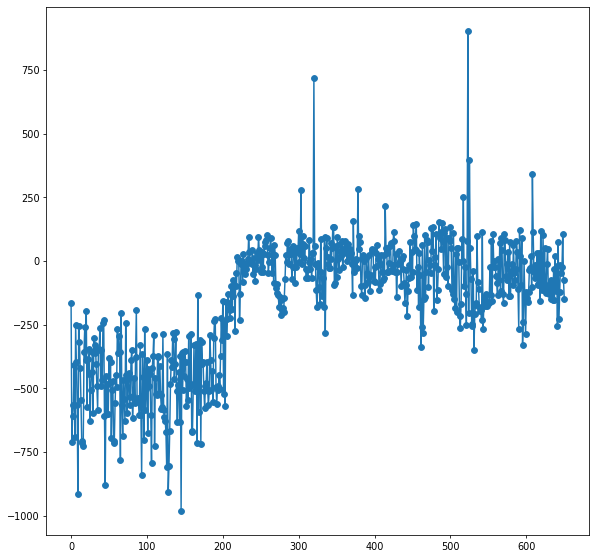

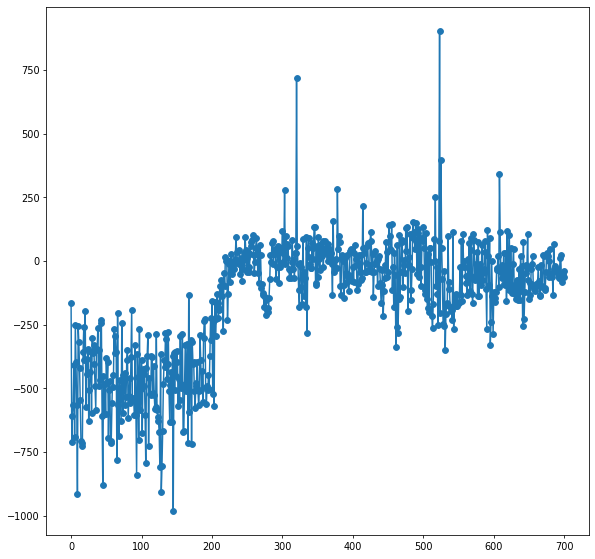

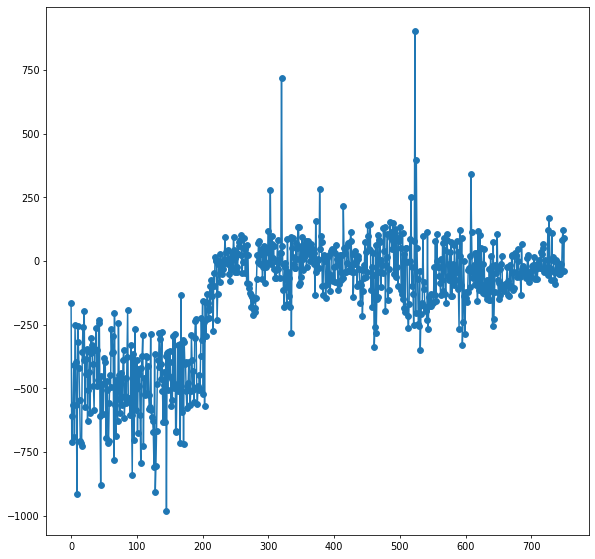

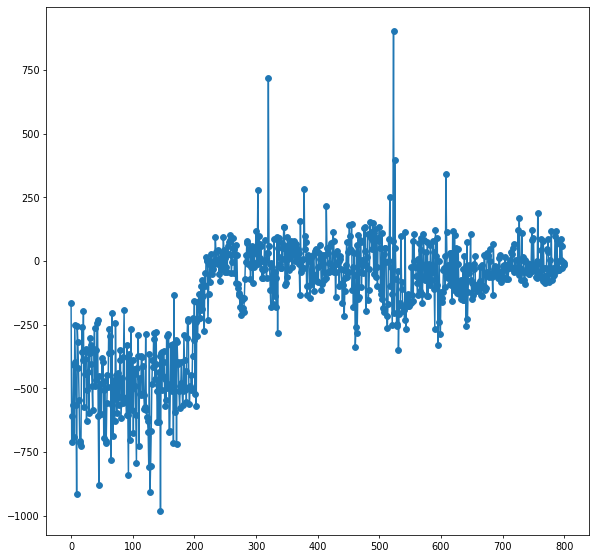

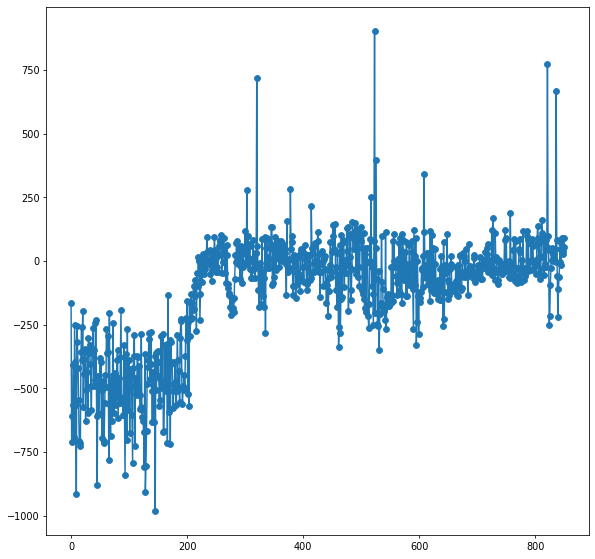

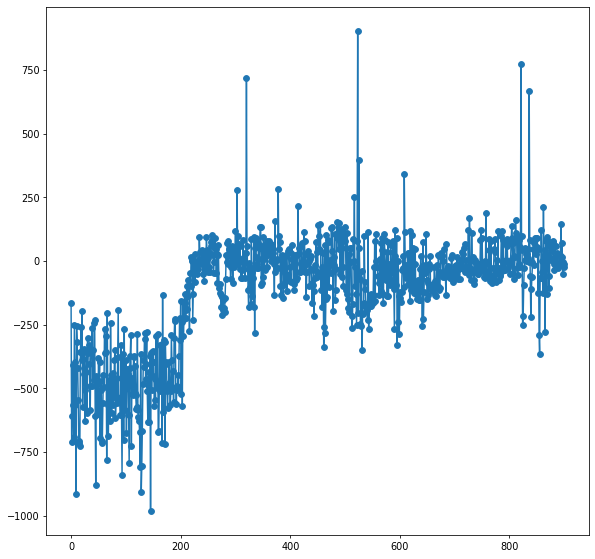

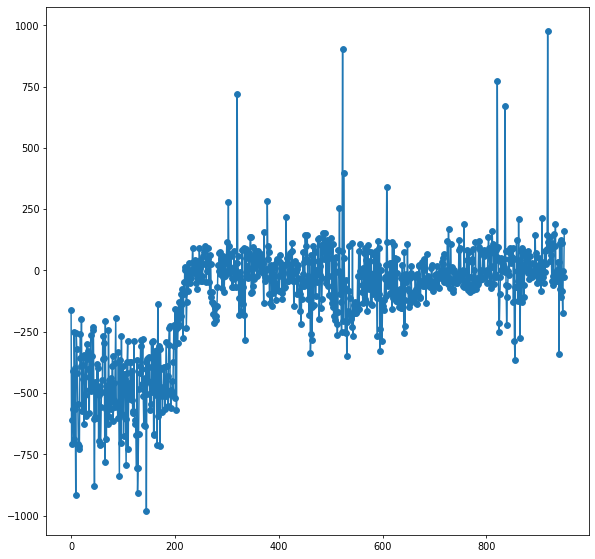

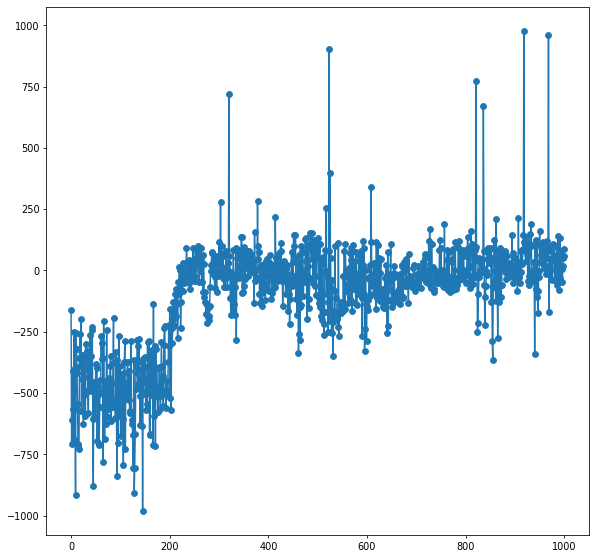

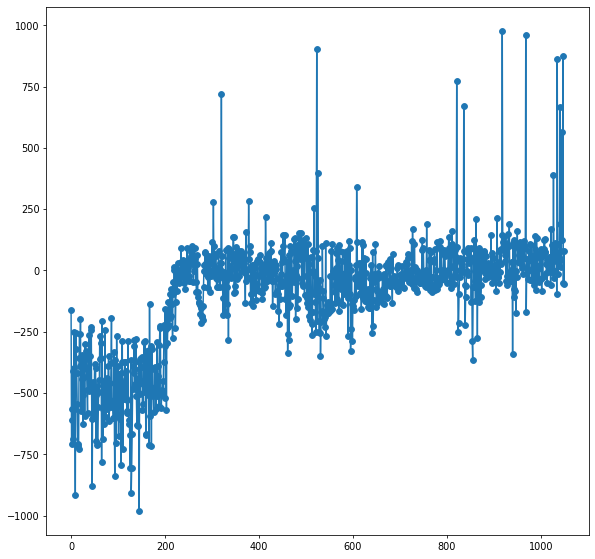

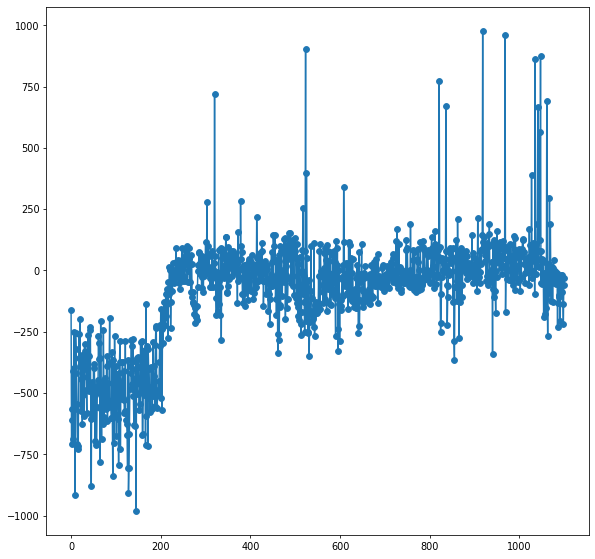

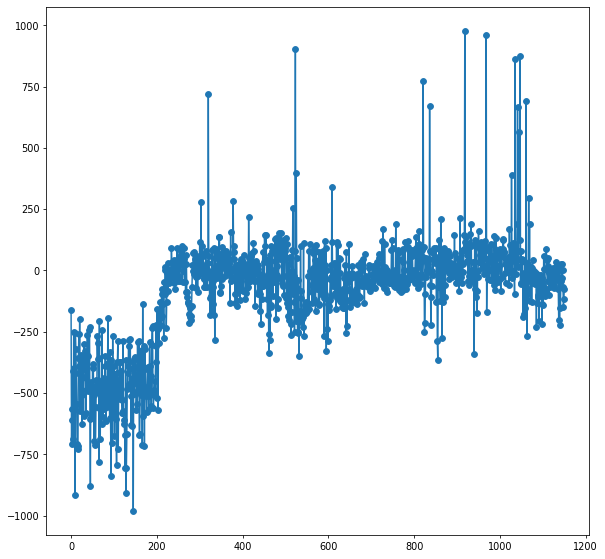

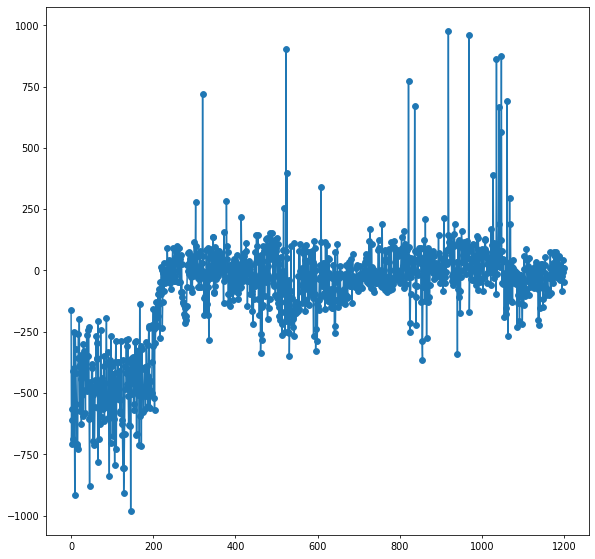

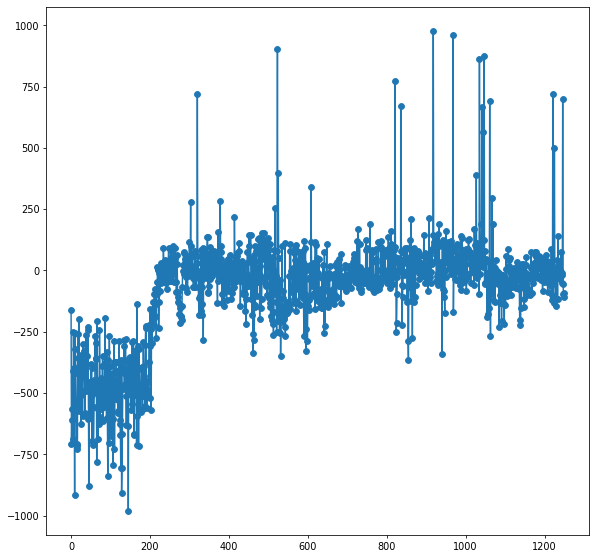

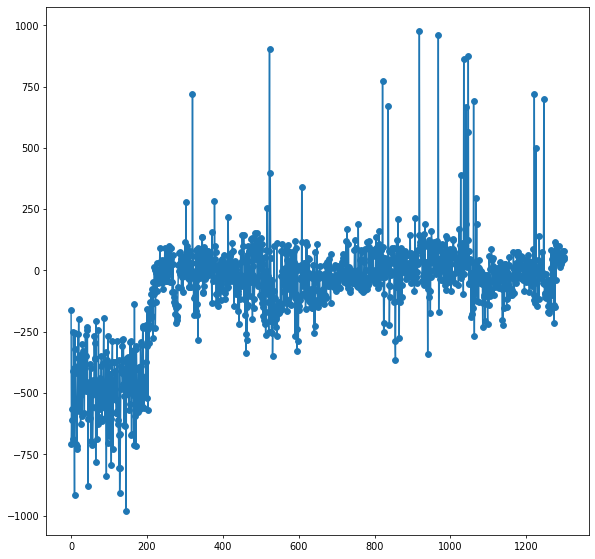

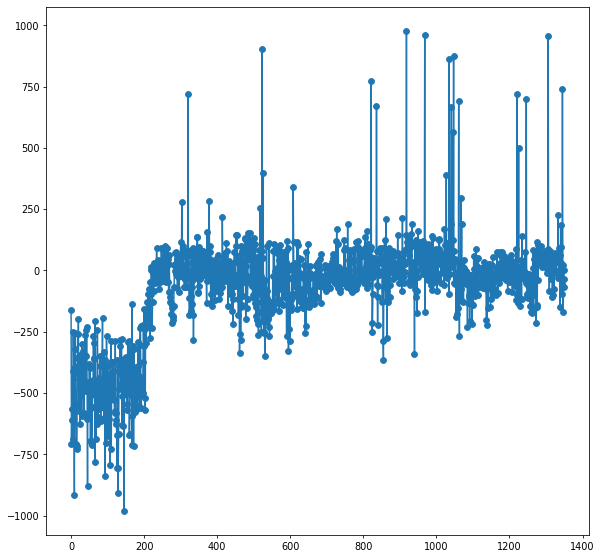

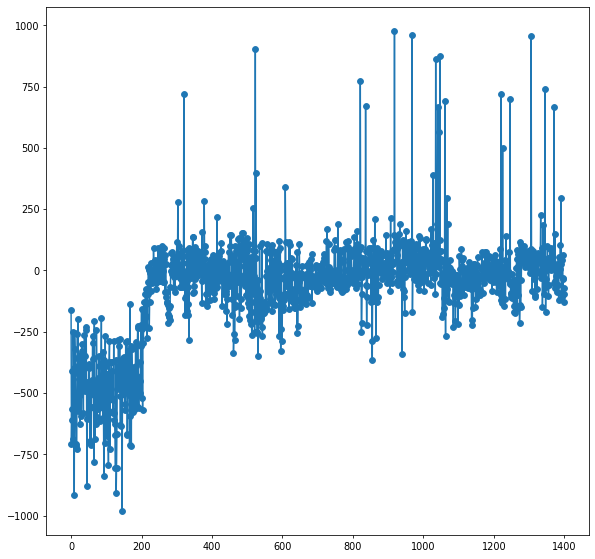

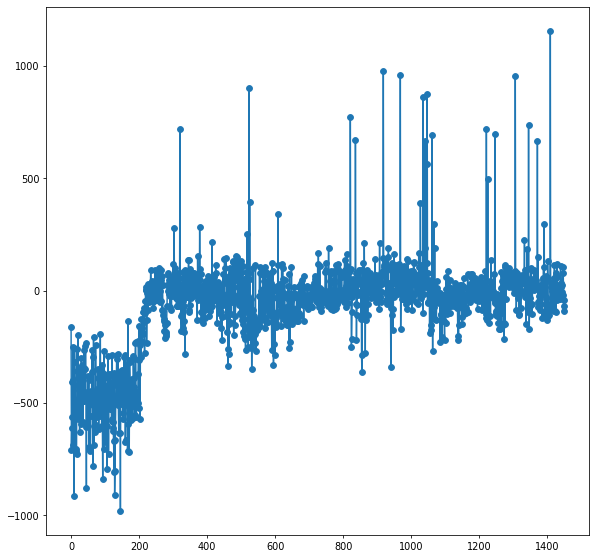

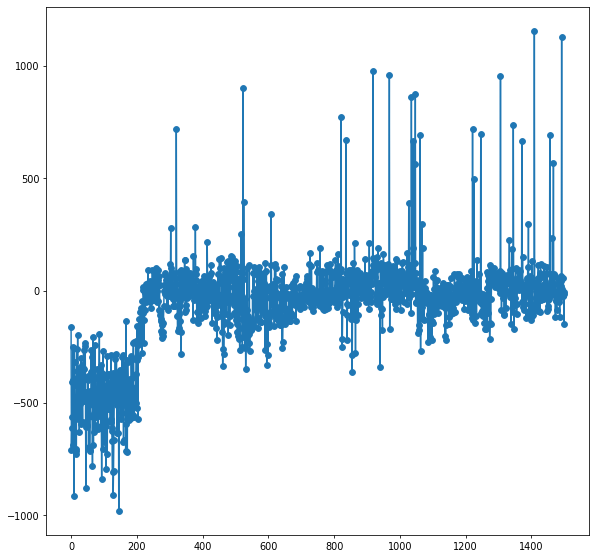

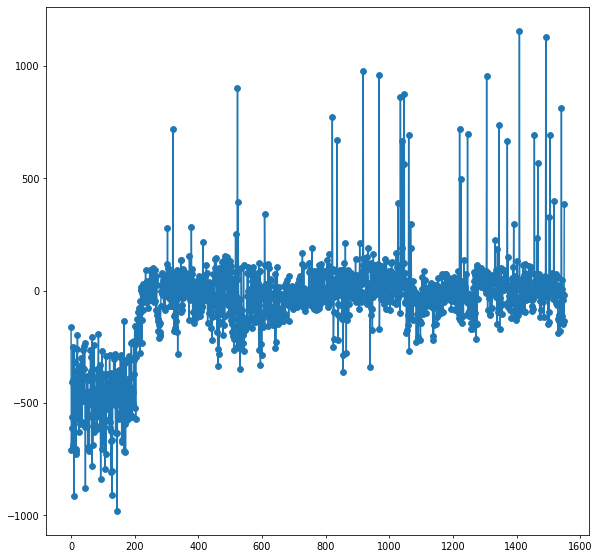

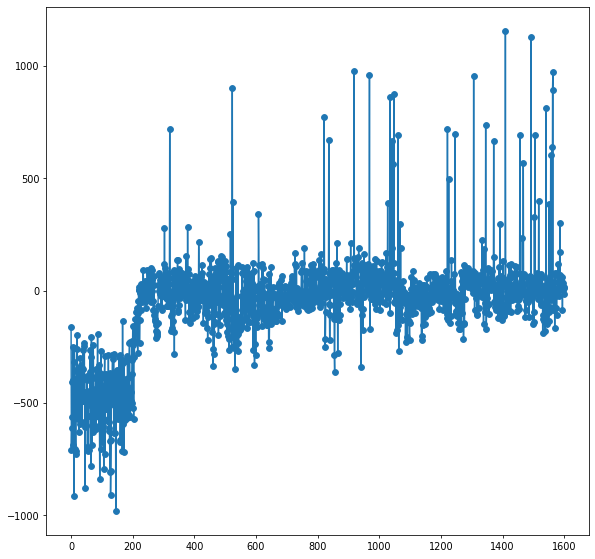

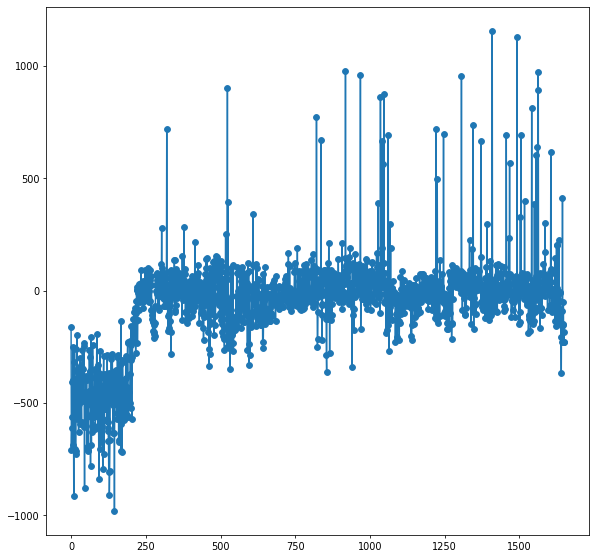

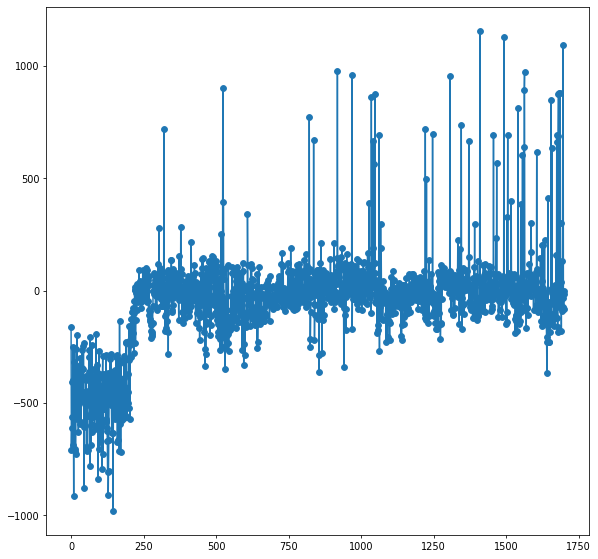

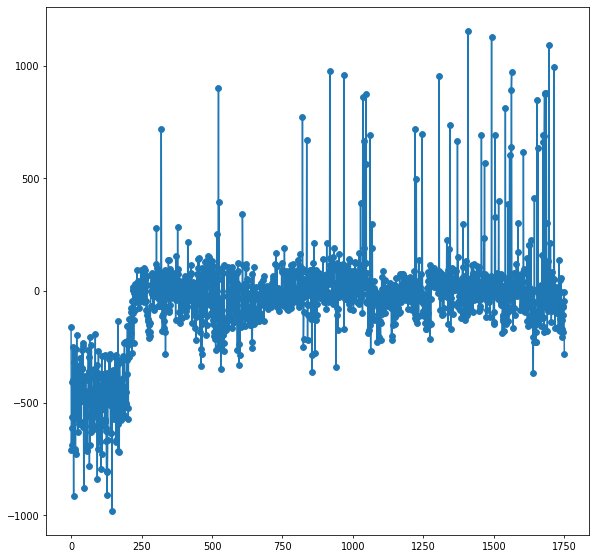

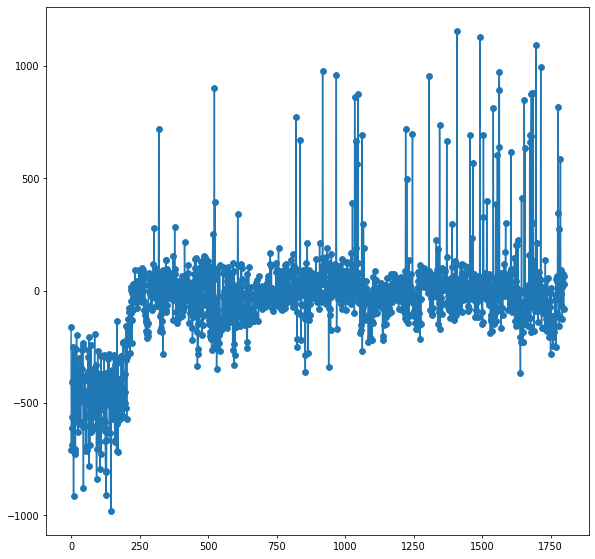

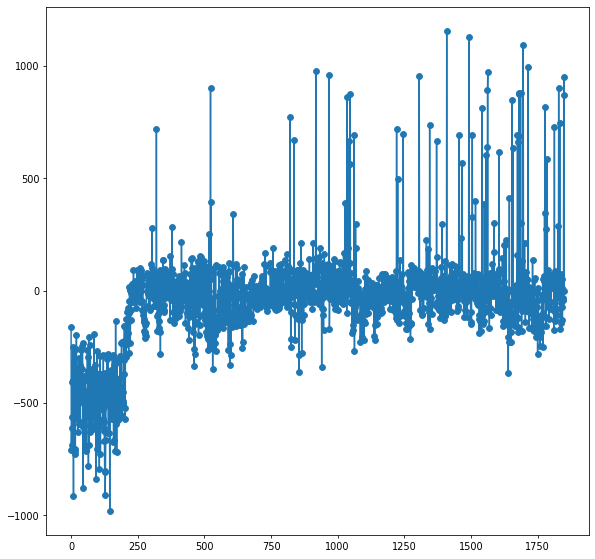

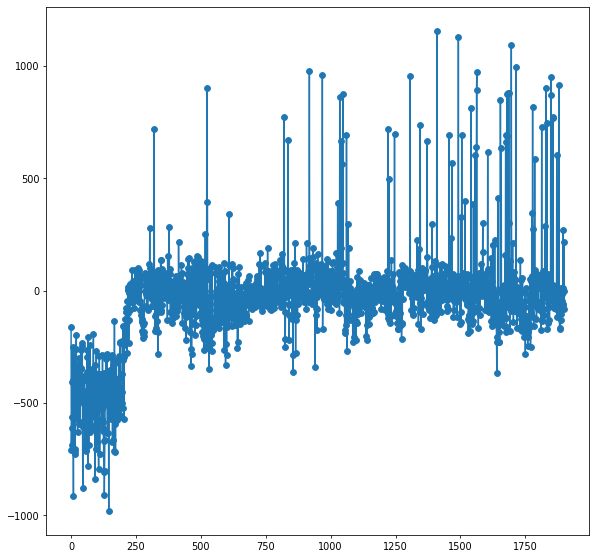

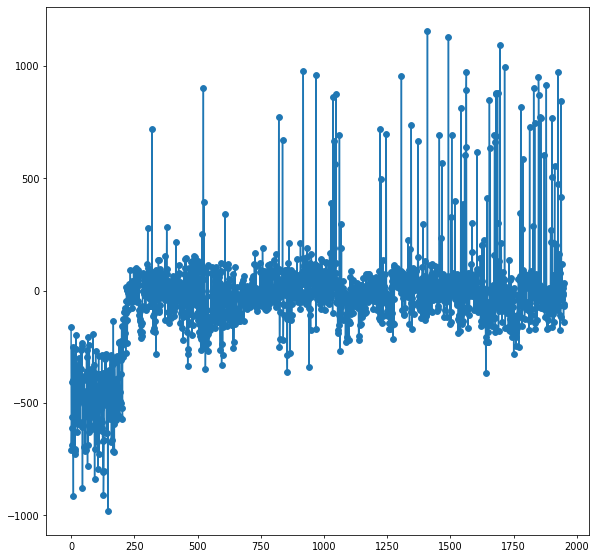

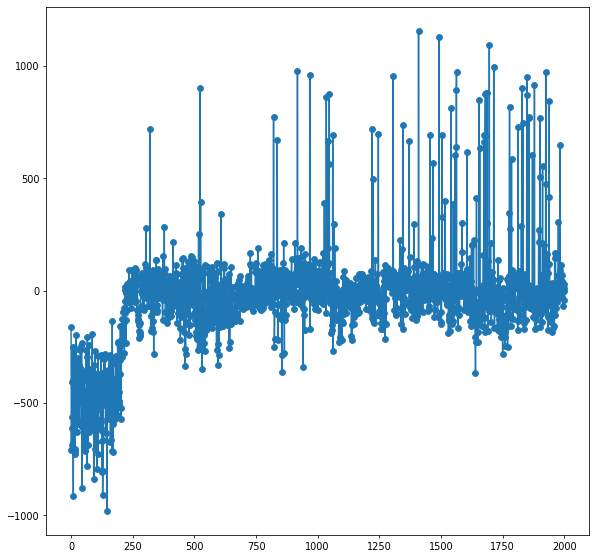

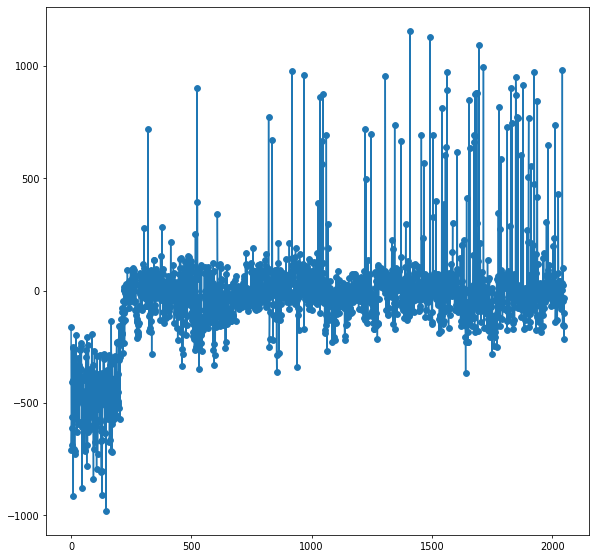

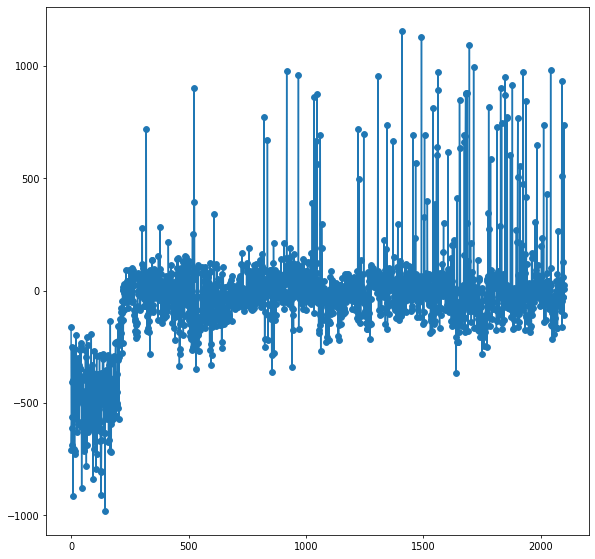

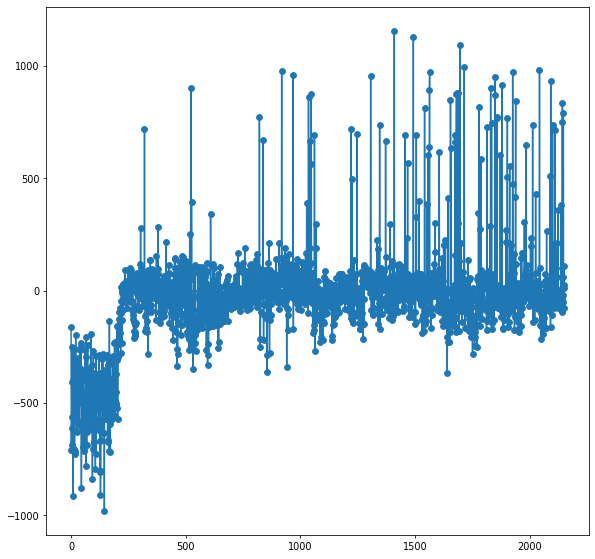

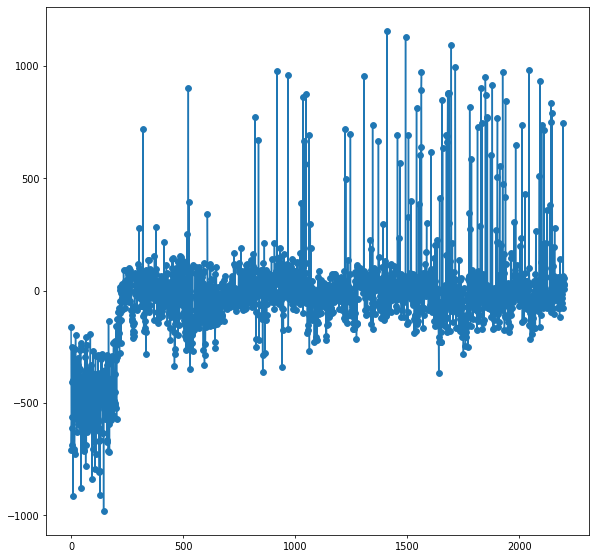

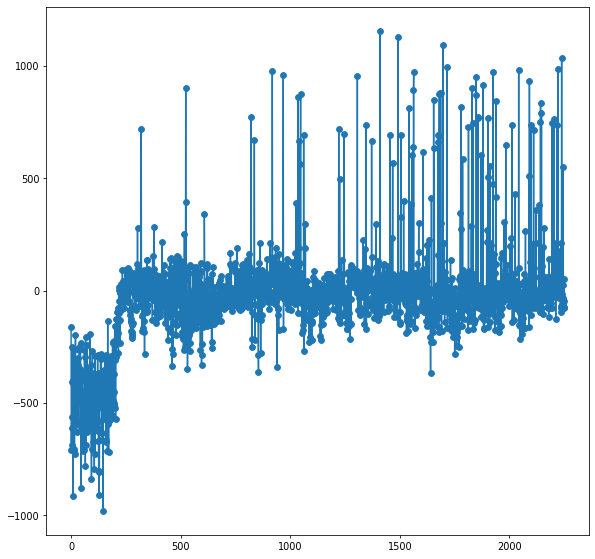

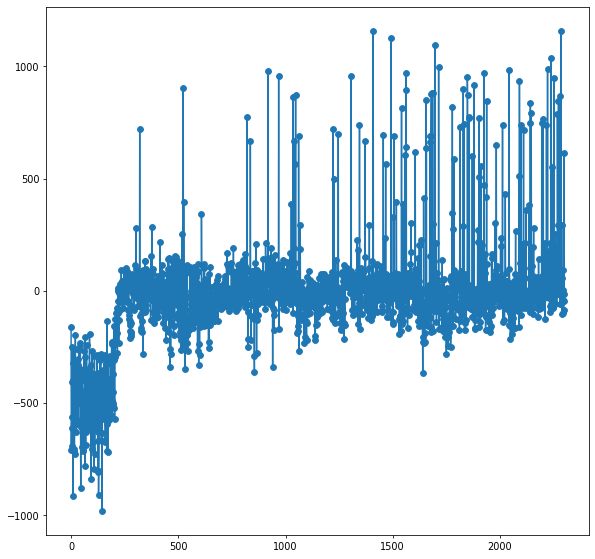

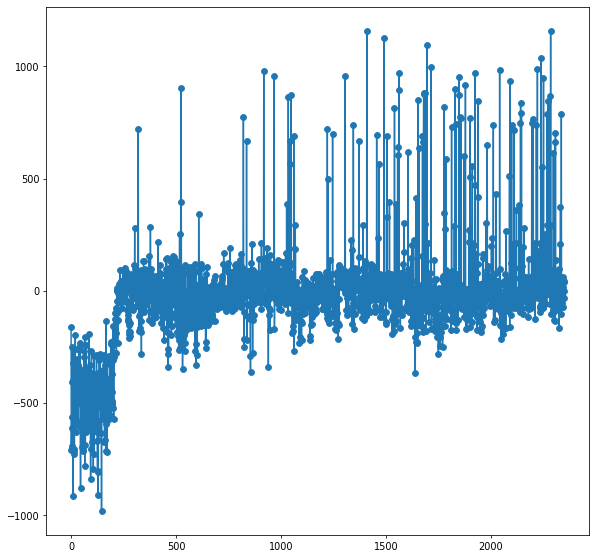

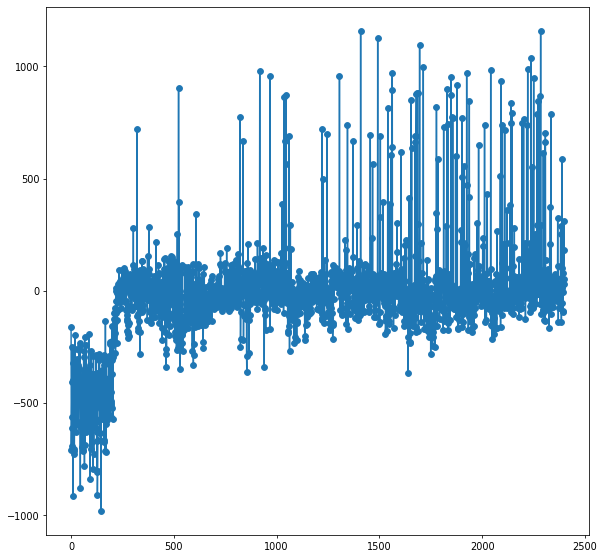

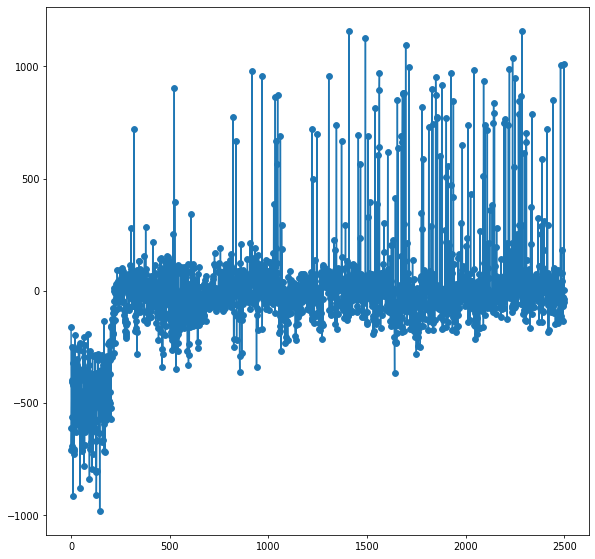

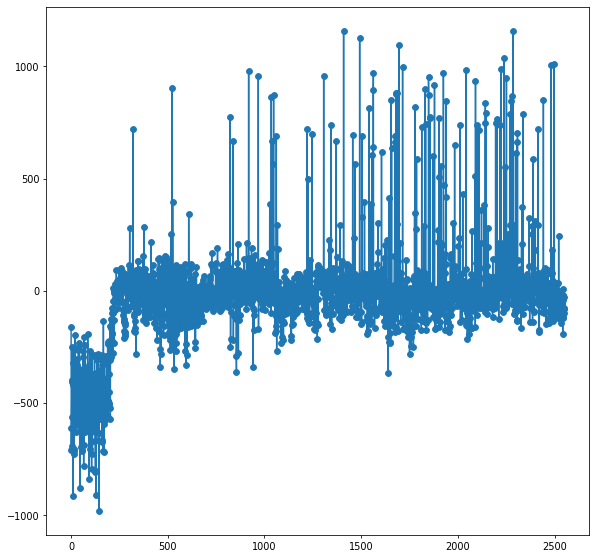

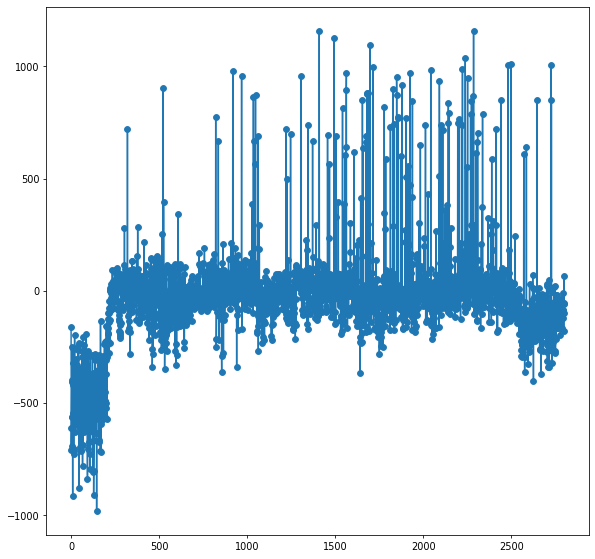

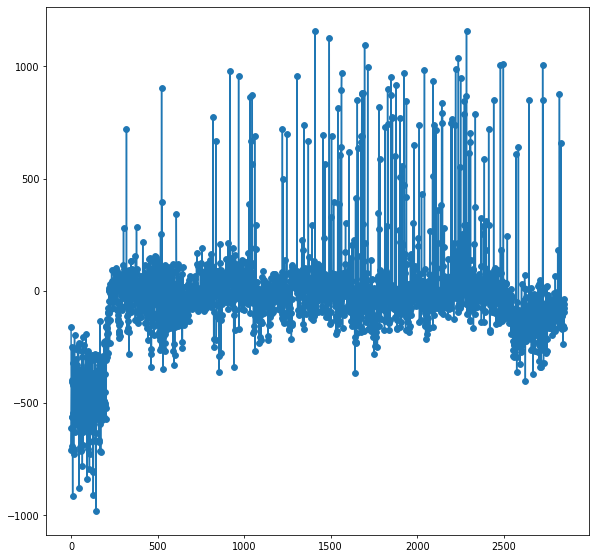

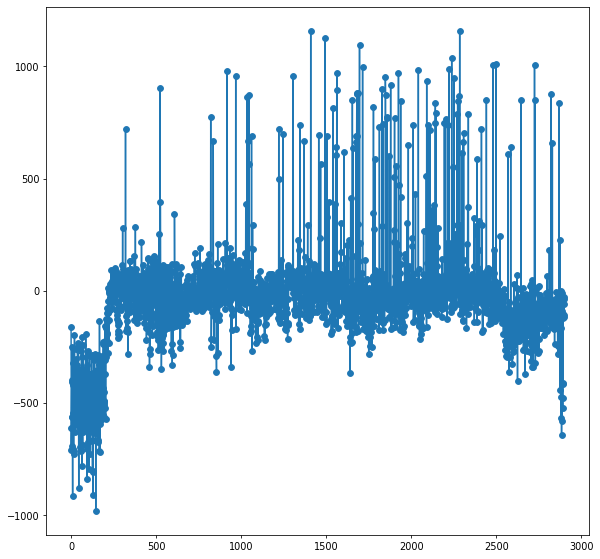

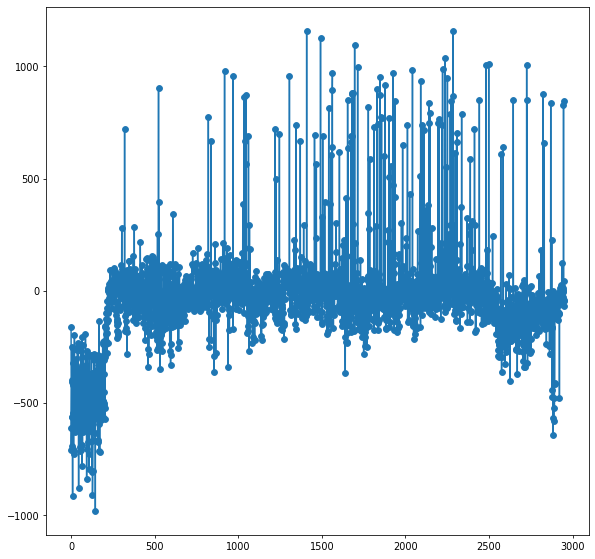

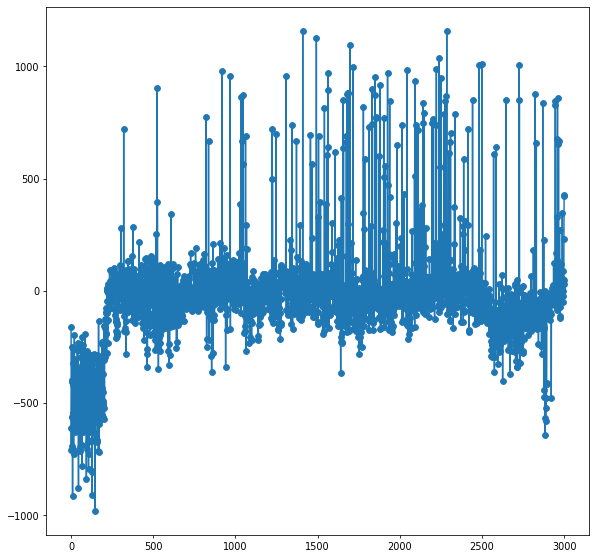

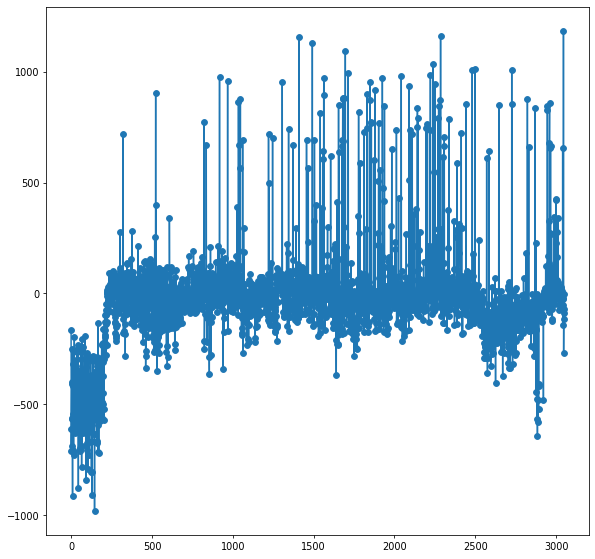

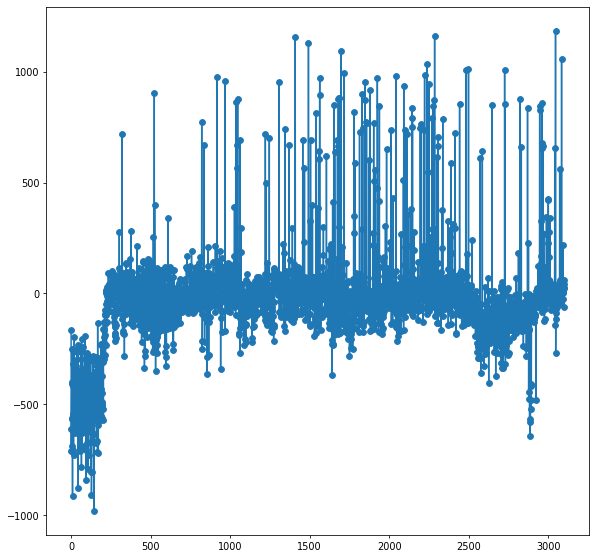

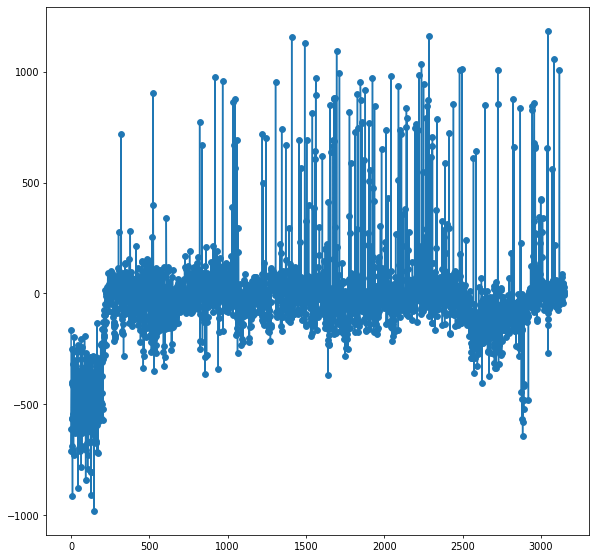

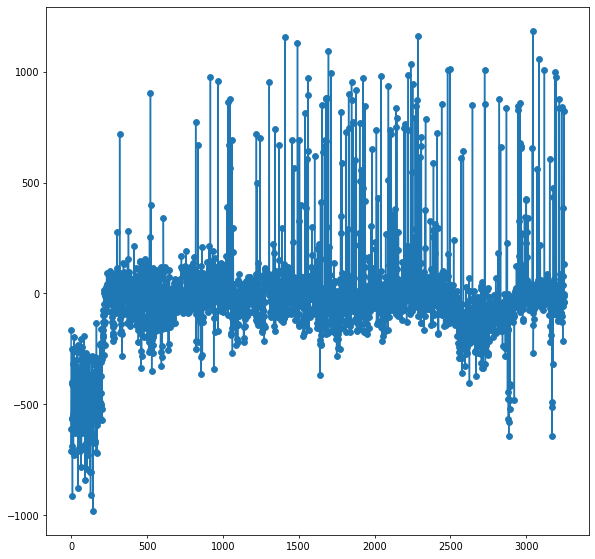

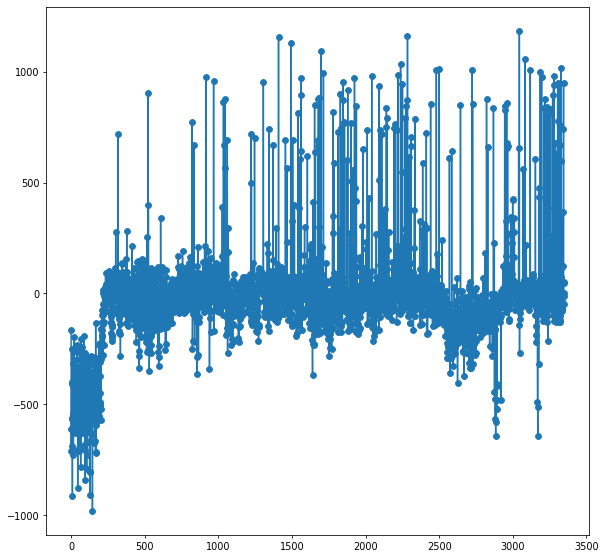

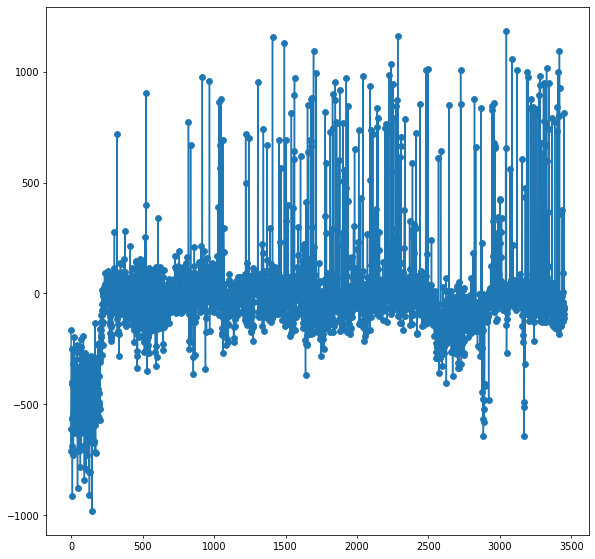

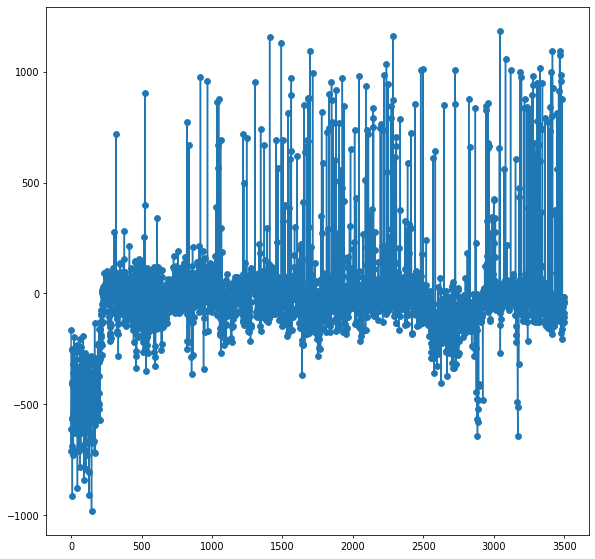

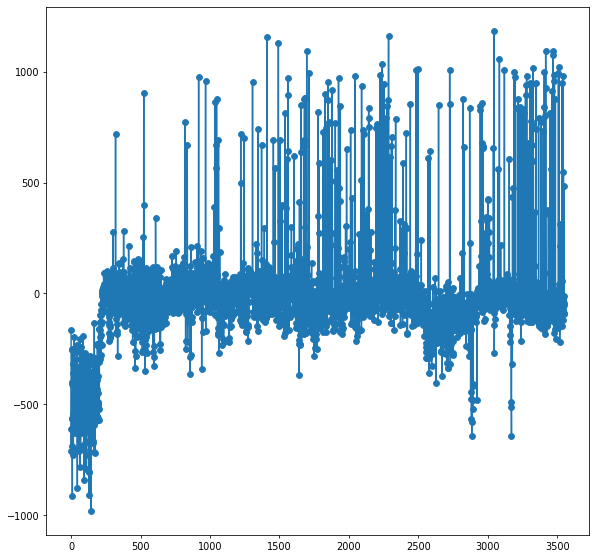

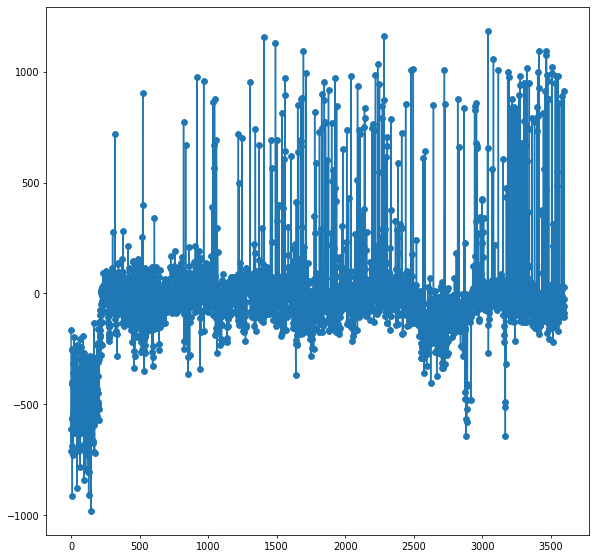

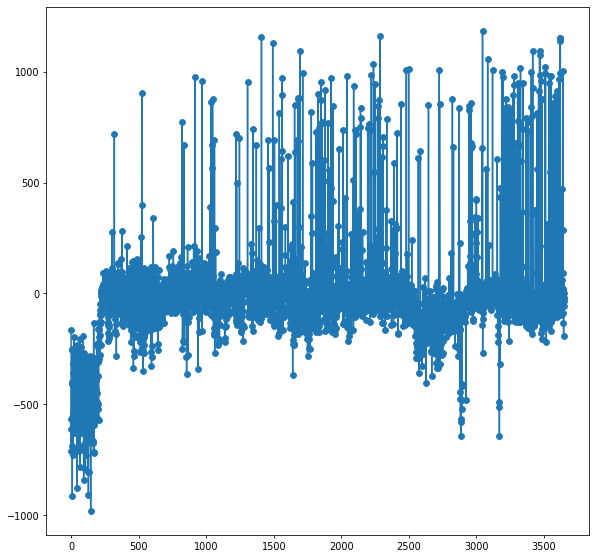

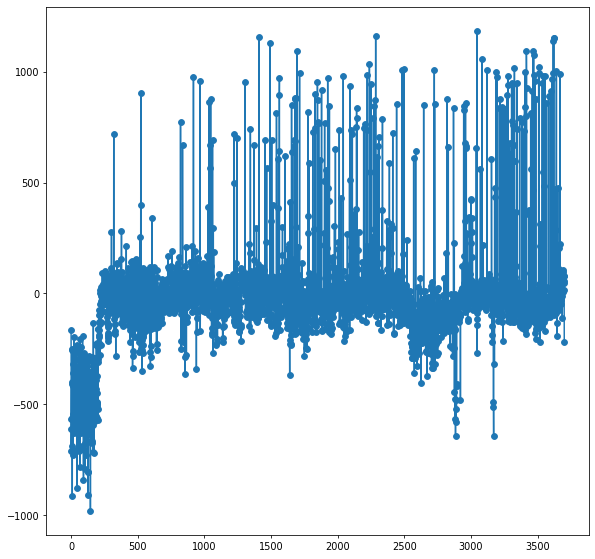

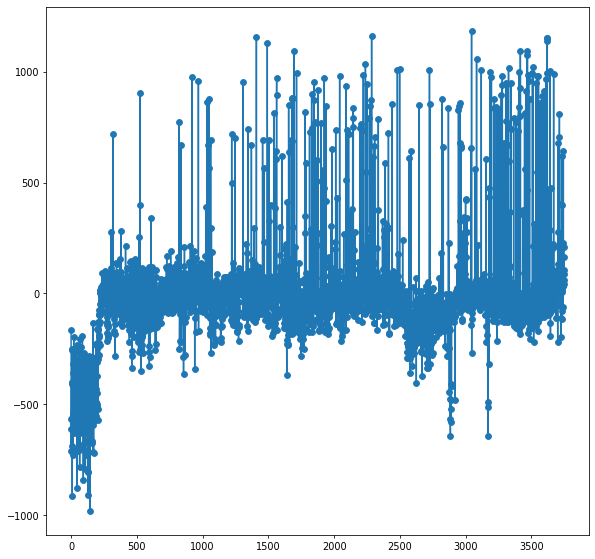

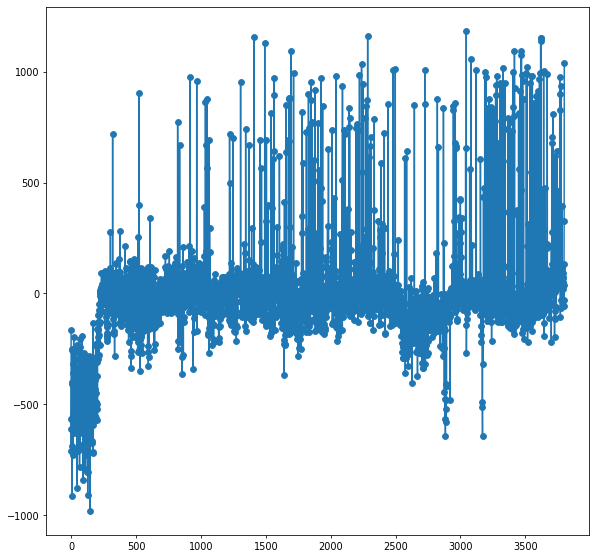

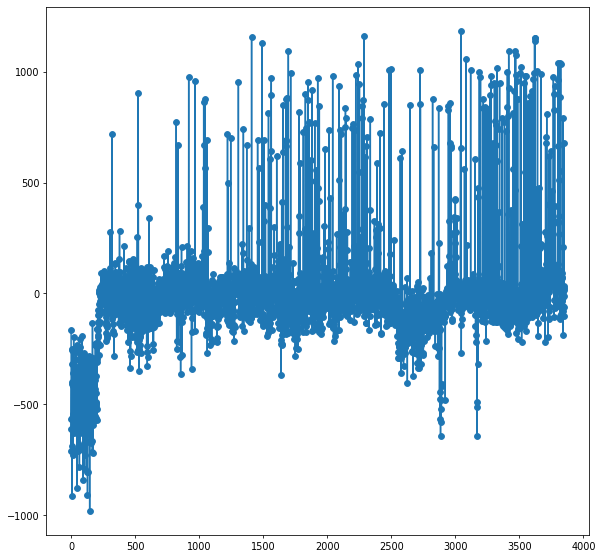

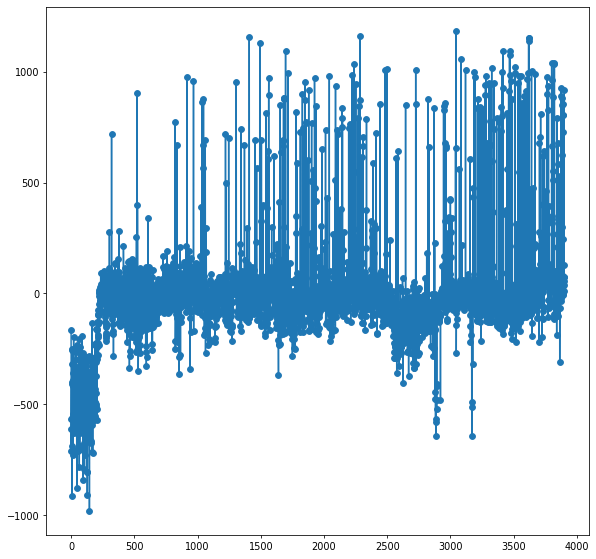

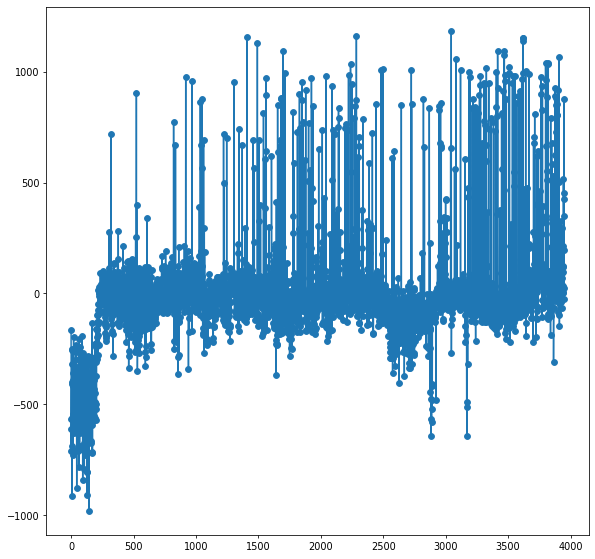

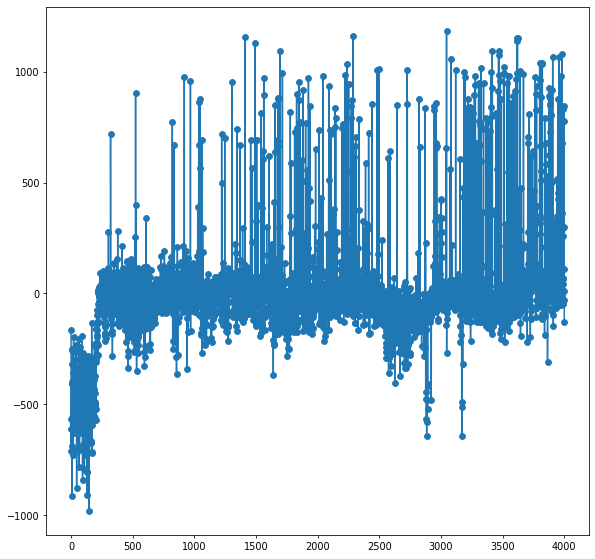

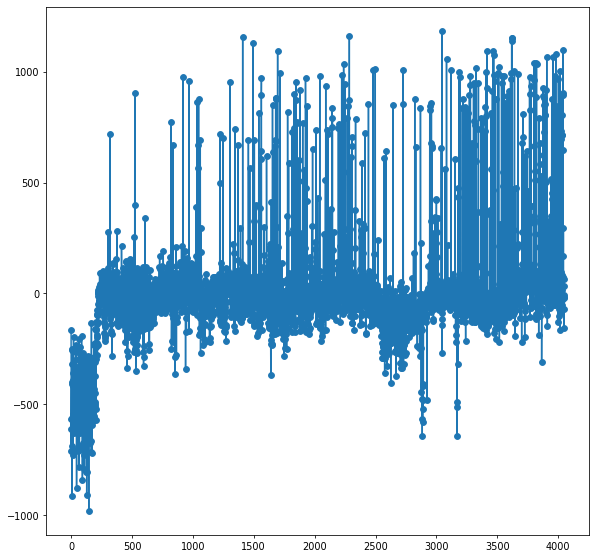

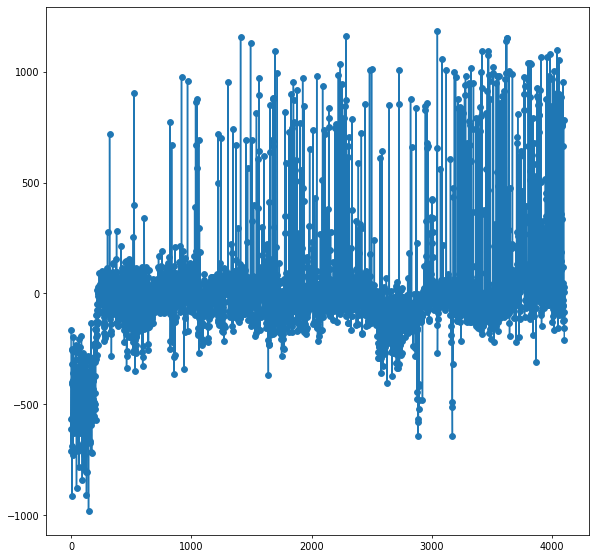

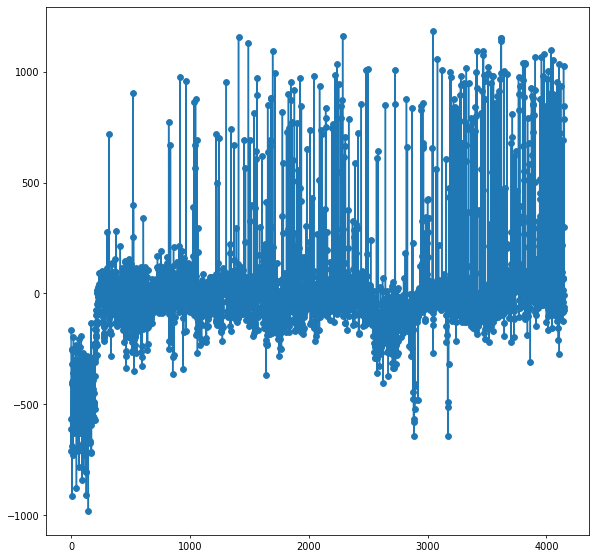

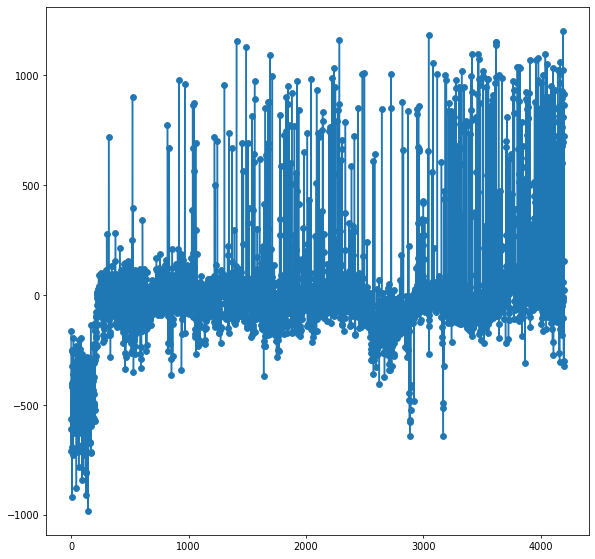

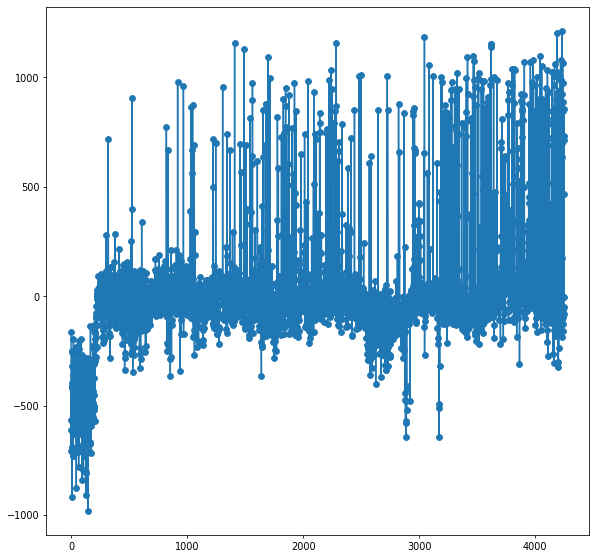

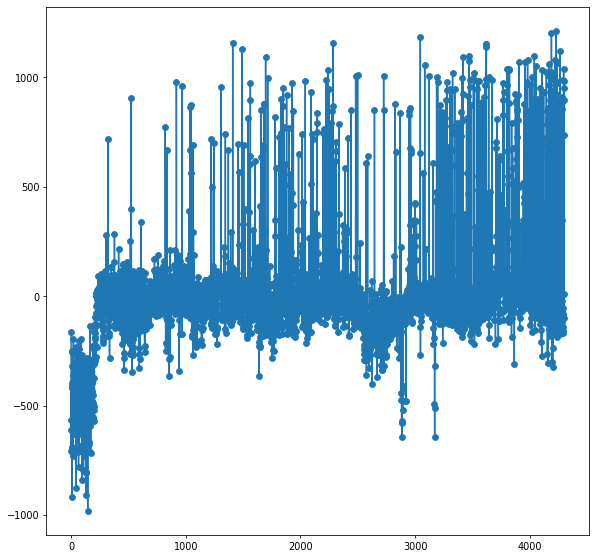

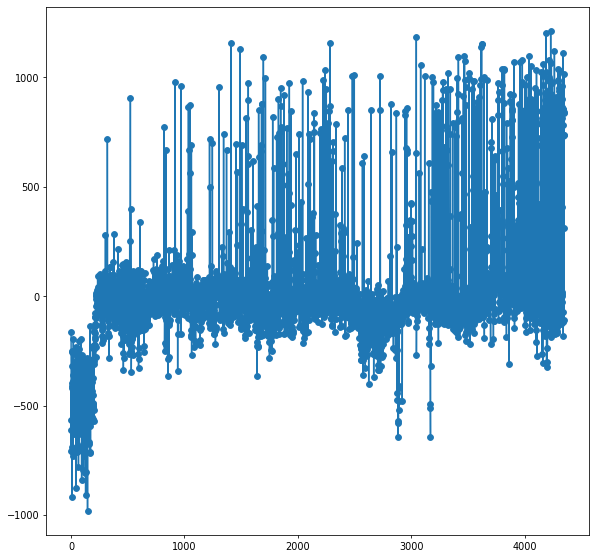

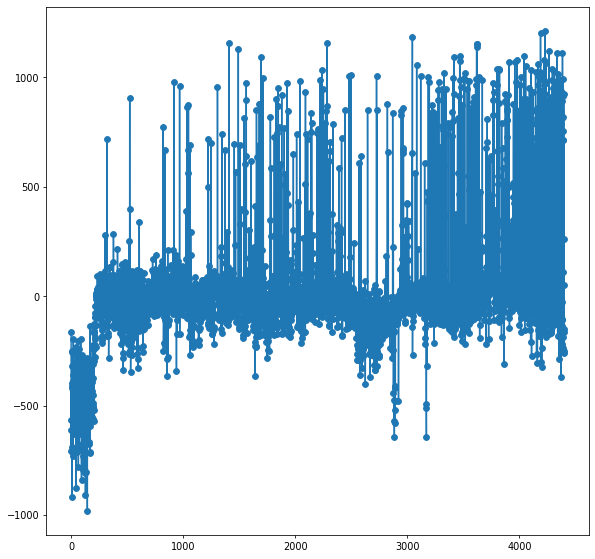

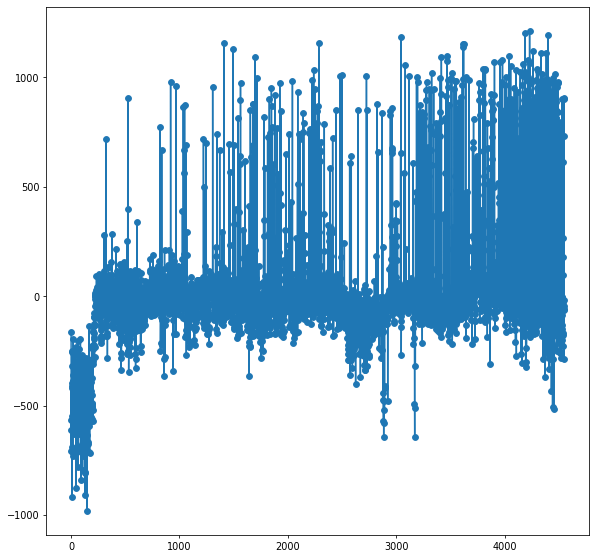

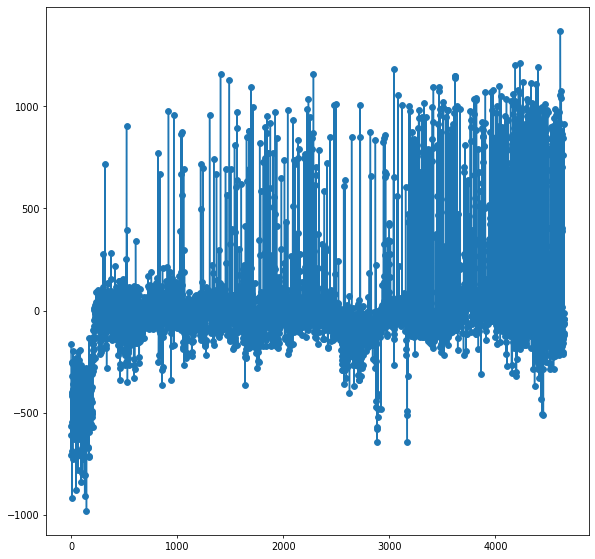

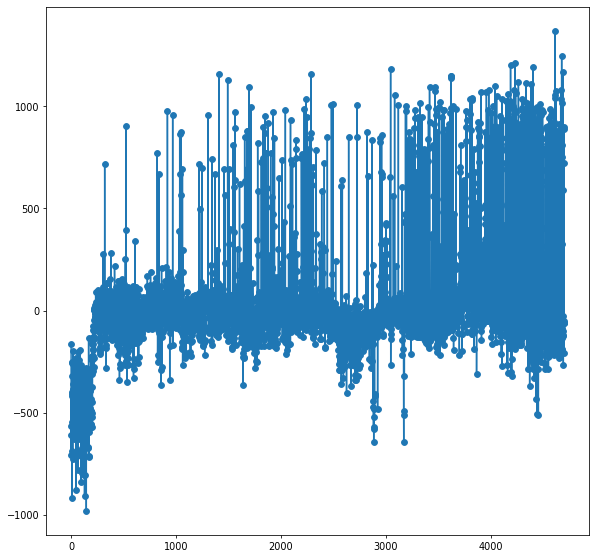

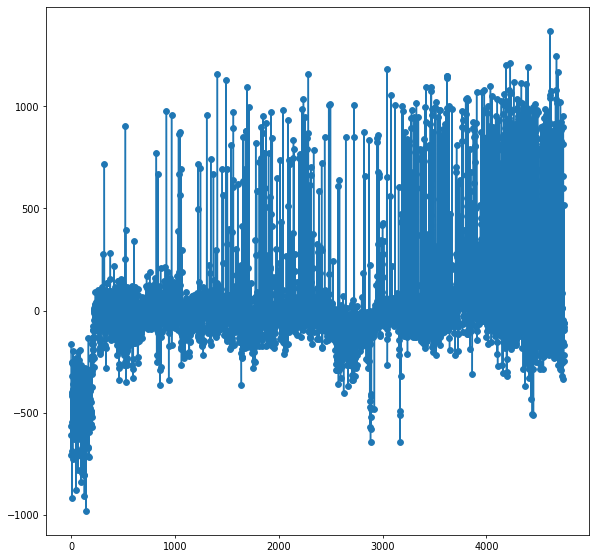

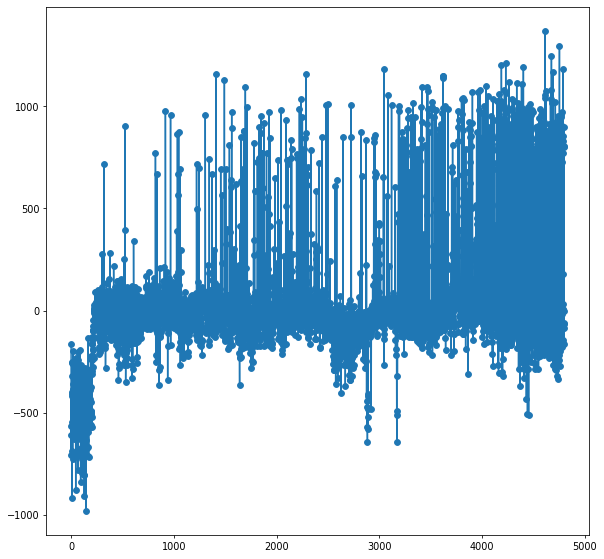

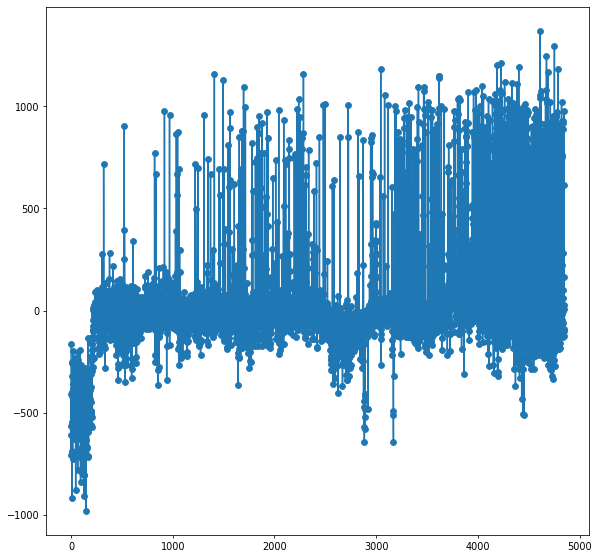

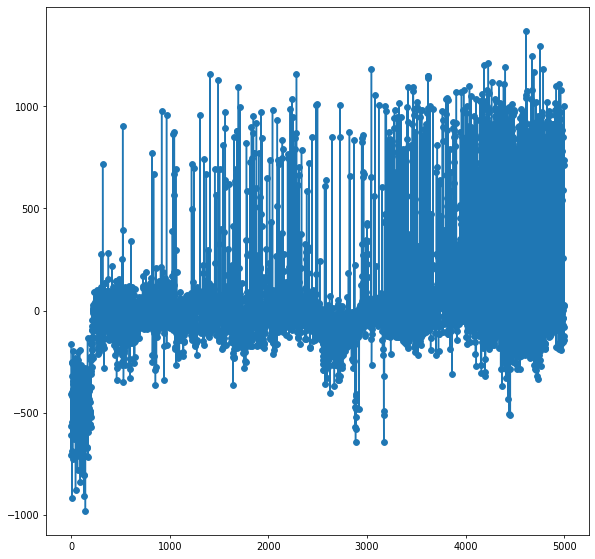

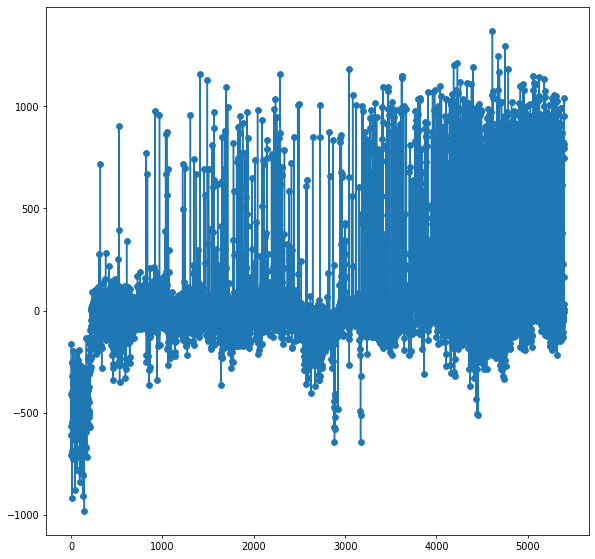

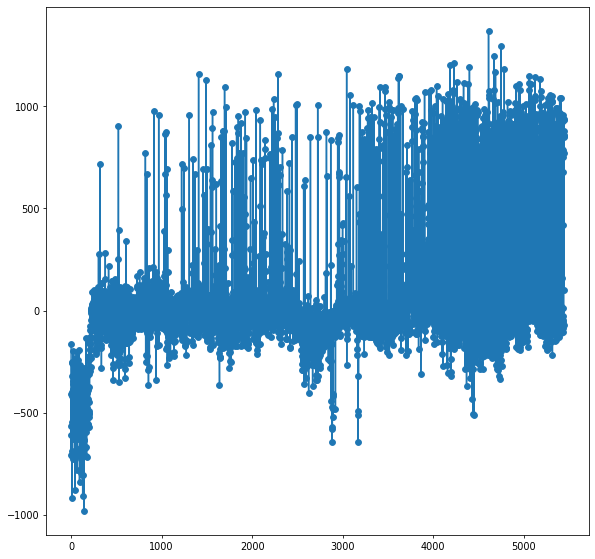

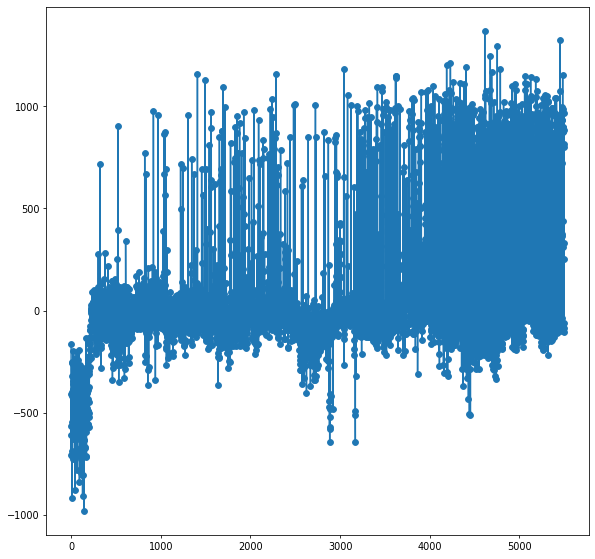

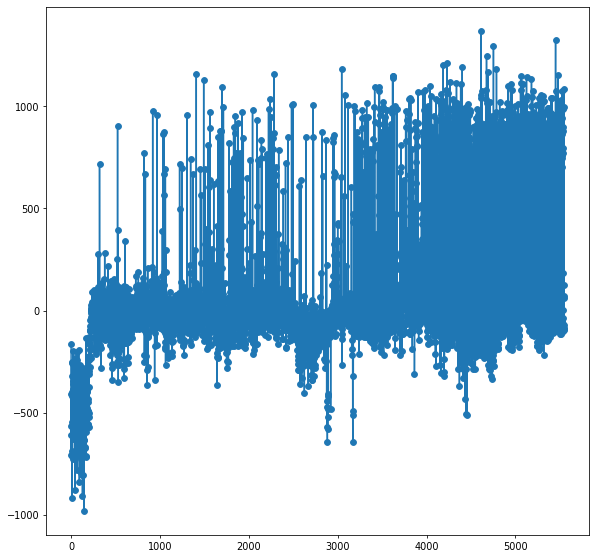

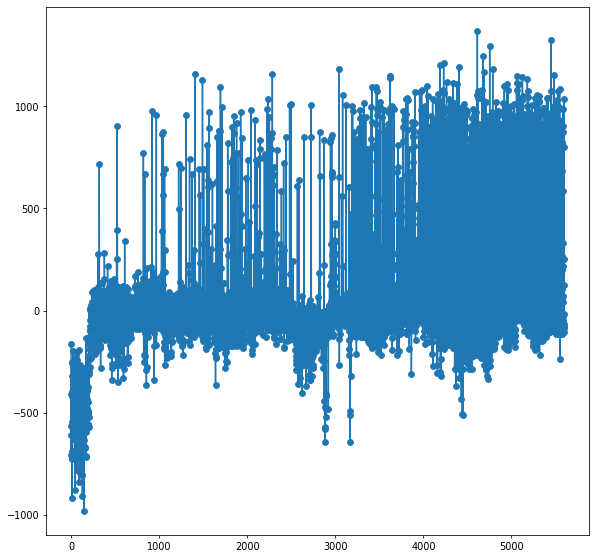

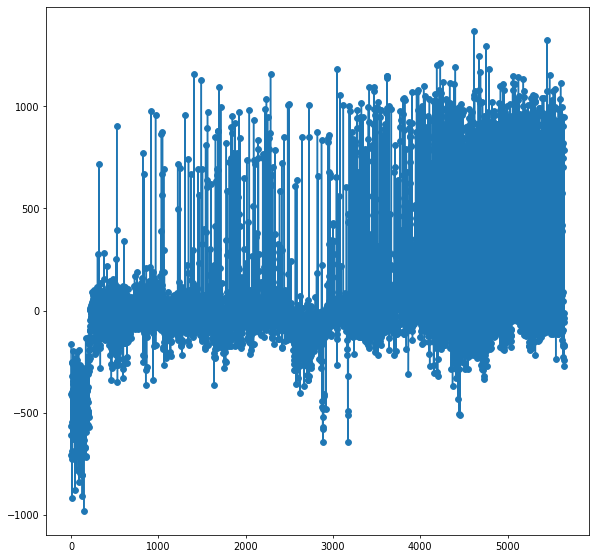

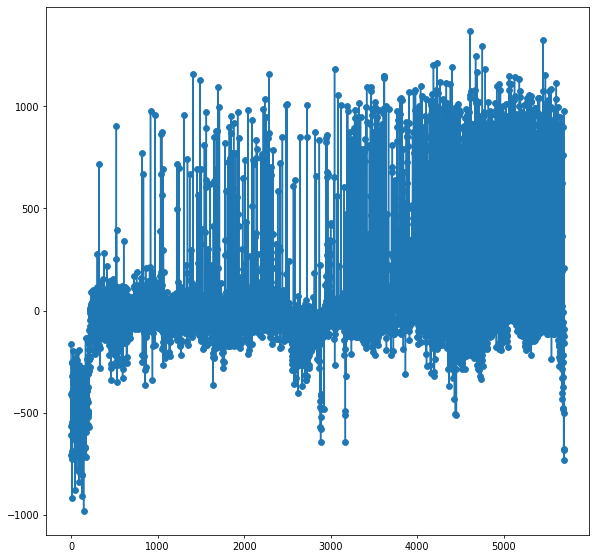

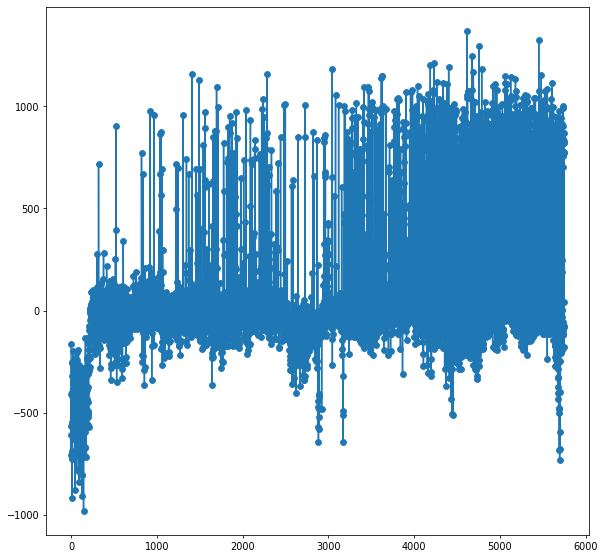

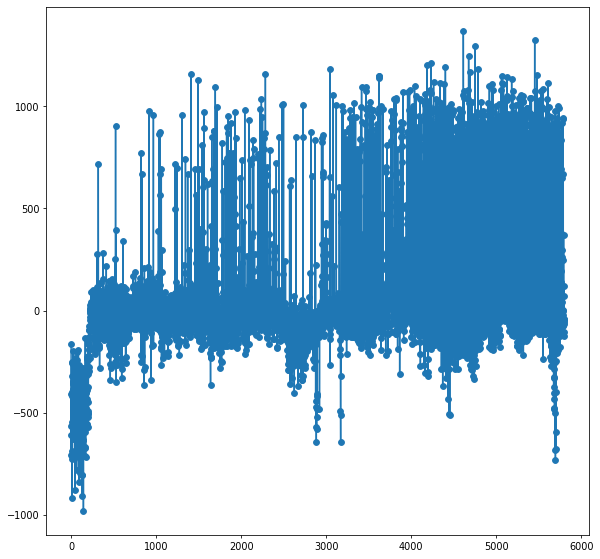

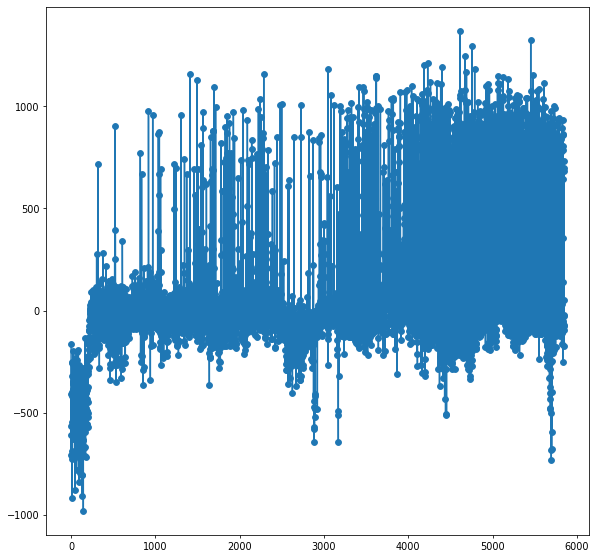

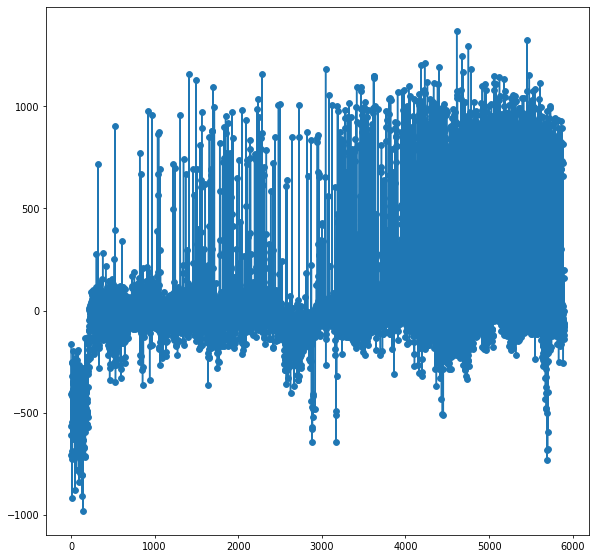

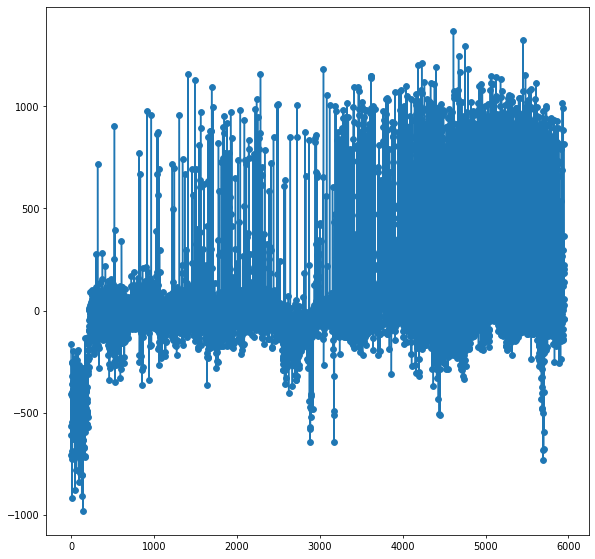

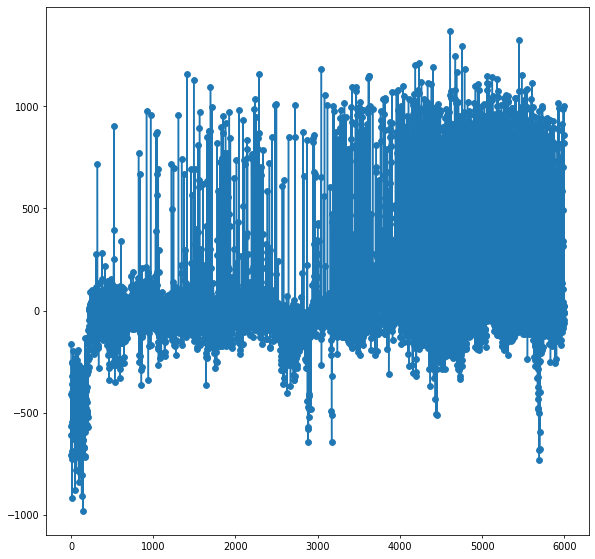

In [3]:
##############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                                             # 动作取值区间,对称区间，故只取上界
hidden_dim = 512
#lr_a = 0.001
#lr_c = 0.001
ddpg = DDPG(a_dim, s_dim, a_bound, hidden_dim)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 0.1

if LOAD_PRETRAIN:
    var = 0.2

list = [1, 2, 7, 8, 9, 11, 14, 18, 33]
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    LEVEL = random.choice(list)
    s = env.reset(level = LEVEL)
    #s = env.reset(level = int(random.choice([1,2,7,8,9])))
    ep_reward = 0
    
    #if i > 500:
        
     #   if lr_a >= 0.000001:
      #      lr_a = lr_a - 0.0000001
       # if lr_c >= 0.000001:
        #    lr_c = lr_c - 0.0000001
    
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            ddpg.Record_success(i)
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        r += info.get('qpos') * 4000
        #print(r)
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward/j)
            
            #if ddpg.pointer > ddpg.memory_capacity and done:
                #RENDER = True
            if (i % CHECK_POINT_EPI) == 0 and i != 0:
                ddpg.save('level_selected_6000_checkpoint/' + str(i) + 'epi')
            
            break
               
print('Running time: ', time.time() - t1)

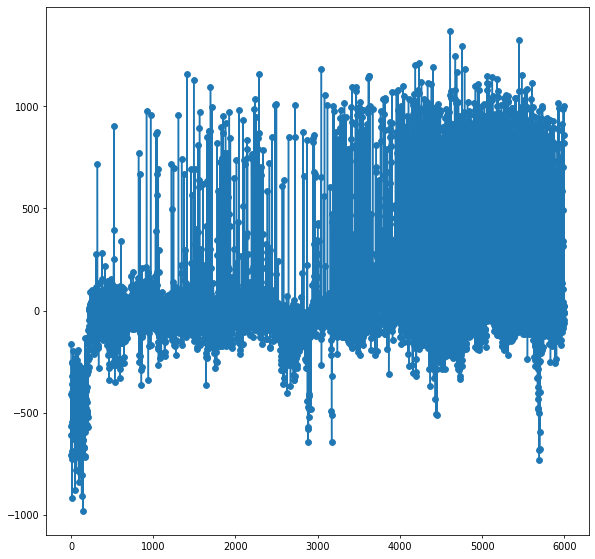

In [4]:
ddpg.save('carbinet_SELF_level_selected_6000EPS')

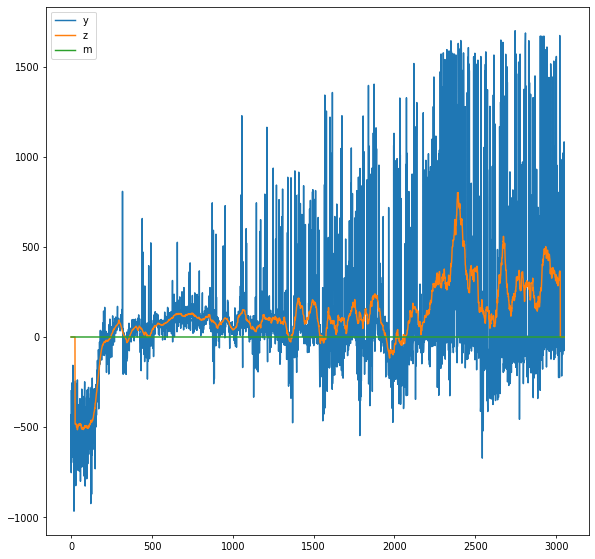

maximum success rate:  0.0
maximum mean rewards:  800.5924504191495


In [8]:
data = pd.read_csv('./DPG model/level12789_check_point_final/3050epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

size = 50

z = np.zeros(len(y))
m = np.zeros(len(y))

#for i in range(len(y)):
#    if y[i] >= 10:
#        y[i] = 0
        
for i in range(len(y)):
    
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward
            
            if(y[i + j - int(size/2)] == 0):
                m[i] += 1                  #success rate
            
                                   
            
        z[i] = z[i] / size
        m[i] = m[i]
        

    
    
plt.figure(figsize=(10, 10), dpi=70)

plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, m)

plt.legend(['y','z','m'])
plt.show()

print('maximum success rate: ', max(m)/50)
print('maximum mean rewards: ', max(z))

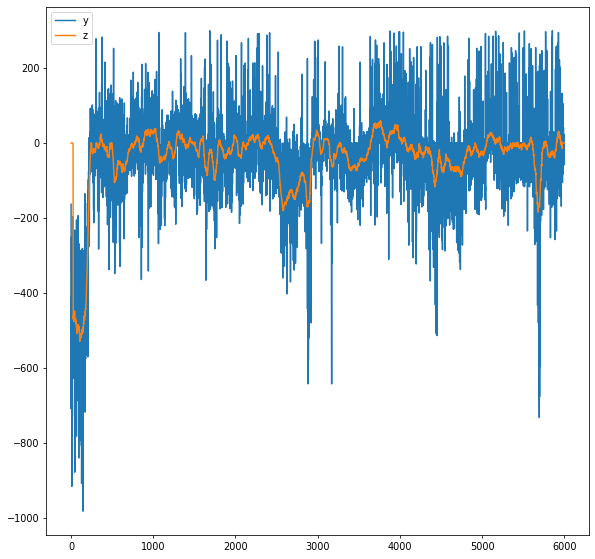

maximum mean rewards:  3765


In [5]:
data = pd.read_csv('./DPG model/level_selected_6000_checkpoint/6000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
size = 50
z = np.zeros(len(y))
for i in range(len(y)):
    if y[i] >= 300:
        y[i] = 0  
for i in range(len(y)):
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward        
    z[i] = z[i]/size
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, y)
plt.plot(x, z)
plt.legend(['y','z'])
plt.show()
print('maximum mean rewards: ', np.argmax(z))

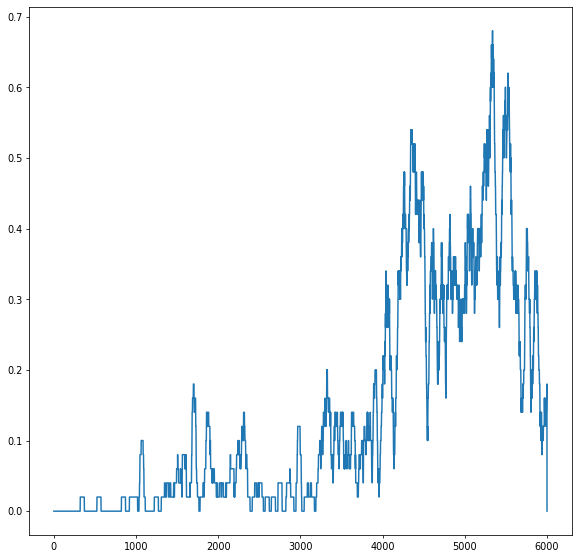

0.68
5336


In [6]:
data = pd.read_csv('./DPG model/level_selected_6000_checkpoint/6000epi/Success_record.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
m = np.zeros(y.shape[0])

for i in range(50,6000):
    for j in range(50):
        if y[i-50+j] == 1:
            m[i] += 1
    m[i] = m[i] / 50   
    
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, m)
plt.show()
print(max(m))#最大值
print(np.argmax(m))#最大值所在位置